<a href="https://colab.research.google.com/github/Lenzeg/Cogsci_blog/blob/master/thesis_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploring What Caused Insomnia Therapy to Relief Self-Rated Depression**
<small>Jupyter notebook for research master thesis Cognitive Neuropsychology by Lennart Zegerius</small>

---


In this notebook I collect variables from both questionnaires and physiological data to use in a model that predicts depression progression.

The features put in the dataframe are for feature engineering purposes mainly and will be narrowed down to fewer features once links have been established.

The axis has been changed of the used data, meaning that instead of multiple rows for multiple timepoints, these values have been put as columns. This makes for easier statistical testing without having to do repeated measures analysis, which is also done because not all timepoints are relevant and most sleep features are only measured at T0.



<br>

**Small Dataset**:

The dataset is roughly:
* 143 subjects
* 550 rows (given sometimes multiple timepoints)
* 220 features (and counting)



---


**Summary**
We have around 230 features and 143 subjects. In this population, treatment using CBTi and a combination with CT has shown statistically significant improvements in self-rated depression scores. The goal of this thesis is to explore the measured dimensions that are likely most important and relevant in attaining this statistical significance. Also, with the aim of involved costs of this study, can we find which measuring tools are relevant/redundant to replicate this study, by analyzing cross-correlation and variable importance?

1. Can we reduce dimensionality just by analyzing cross-correlation, regardless of it’s relation with self-rated depression?
2. Can we use advanced statistical tools to further detect variable redundancy (as a sort of cost-benefit analysis)?
  1. Can we do this using PCA, by utilizing:
    1. Domain specific principal components
    2. Complete dataframe principal components
    3. Variables important in principal component analysis
  2. Can we do this using T-SNE as an alternative?
3. Can we find the relative contribution of domain-specific measuring tools’ explained variance in relieving subjective depression scale (self-rated)?
4. Can we use machine learning to build models using reduced the dimensionality achieved in steps 1,2,3, that further explore the relative contribution of the measuring tools’ explained variance in relieving subjective depression scale (self-rated)?
  1. Using PCA (linear), T-SNE (non-linear), highest ranking variables
    1. Models such as XGBoost and Random Forests have feature importance metrics such as Gini impurity, permutation feature importance & SHAP values.
  2. Can we do hyperparameter tuning to improve the model’s performance?
  3. What explained variance can we achieve in a regression model?
  4. What accuracy can we achieve in a classification model, utilizing the clinically relevant treatment response in Leerssen, 2021?


---




### **Libraries**

In [1]:
%%capture

# Uncomment first run
!pip install ptitprince
!pip install plotly
!pip install bayesian-optimization
!pip install eli5
!pip install shap
!pip install pdpbox


# Basic
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.collections as clt
import ptitprince as pt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


# Preprocessing 
from sklearn.feature_selection import SelectKBest, f_regression, chi2, mutual_info_regression, r_regression
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Eval & Feature importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
import eli5
from eli5.sklearn import PermutationImportance
import shap
from pdpbox import pdp, get_dataset, info_plots




# Printing Values

# pd.set_option('display.max_rows', None)
pd.set_option('max_columns', None)
# pd.set_option("max_rows", None)
# np.set_printoptions(threshold=np.inf)
# pd.options.mode.chained_assignment = None  # default='warn'


# Data Processing

### **Import Variables from Questionnaires**

**IDS-SR**: T0,T1,T2,T3,T4

**ISI**: T0,T1,T2,T3,T4


**ITQ** 

| Abbreviation | Description
| --- | --- |
| ACS | Action Control Scale |
| BAS | Behavioural System and Activation System Scale |
| SHS | Subjective Happiness Scale |
| RPAS | Response to Positive Affect |
| RRS | Ruminative Response Scale |
| MINI-IPIP | Mini International Personality Item Pool |
| PANAS | Positive and Negative Affect Scale |
| TEPS | Temporal Experience of Pleasure |
| PI | Perfectionism Inventory |
| FIRST | Ford Insomnia Response to Stress Test |
| PSAS | Pre-sleep Arousal Scale |
| FSS | Fatigue Severity Scale |
| ISI | Insomnia Severity Index |
| CTQ | Childhood Trauma Questionnaire |


**Insomnia Subtypes**

| Subtype | Description 
| --- | --- |
| 0 | Control |
| 1 | Highly Distressed |
| 2 | Moderately Distressed + Reward Sensitive |
| 3 | Moderately Distressed - Reward Sensitive |
| 4 | Low Distress + Highly Reactive |
| 5 | Low Distress + Low Reactive |



**Actigraphy**

| Name | Meaning 
| --- | --- |
| TIB | Time In Bed |
| TST | Total Sleep Time |
| SE | Sleep Efficiency |
| SO | Sleep Onset |
| WASO | Wake After Sleep Onset |
| SOW | Sleep Opportunity Window |
| Mean_Temp | Mean night temperature |
| Bedtime_Dec_Hr | Bedtime in decimals |
| EyesClosed_Dec_Hr | Subjective eyes closed moment in decimals |
| SleepOpEnd_Dec_Hr | Sleep opportunity ending in decimals |
| Getuptime_Dec_Hr | Get up time in decimals |
| Mid-sleep_time_dec_hr | Sleep onset + half of total sleep time in decimals |
| Mean_Temp_Cr_of_Grav_Dec_Hr | Decimal Time point in the night where the center of gravity of the temperature is |
| Cr_of_grav_to_Mid_sleep_delay_Dec_Hr | Center of gravity in relation to mid sleep delay in decimals |


**Consensus Sleep Diary**

| Name | Meaning 
| --- | --- |
| CSDM_TIB_Recalc | a somewhat-24 hour decimal value of time in bed |
| CSDM_SOW_Recalc | ^ but sleep opportunity window |
| CSDM_TST_Recalc | ^ but total sleep time |
| CSDM_SEtib_Recalc | ^ but sleep efficiency during time in bed |
| CSDM_SEsow_Recalc | ^ but sleep efficiency during sleep opportunity window |
| CSD_Bedtime_Dec_Hr | Bedtime in decimals |
| CSD_EyesClosed_Dec_Her | Time Decimal of remembered closing of eyes |
| CSD_SleepOpEnd_Dec_Hr | Time Decimal when the sleep opportunity ended |
| CSD_SOL_min | Time Decimal of sleep onset latency in minutes |
| CSD_LogSOL+1 | Time Decimal of sleep onset latency but the logtransform to remove skewing |
| CSD_WASO_num | Number of wakeful moments after sleep onset |
| CSD_logWASO_num+1 | Log because skewed |
| CSD_WASO_min | Total time of wakeful moments |
| CSD_EMA_min | Estimated Minutes/Moments Awake |
| logCSD_EMA_min+1 | Log because skewed |
| CSD_Getuptime_Dec_Hr | Time Decimal of Estimated Get Up Time |
| CSD_Mid-Sleep_Time_Dec_Hr | Sleep Onset Dec Hr + Half of total assumed sleep time |
| CSD_Qualit | How would you rate your sleep? (0-4) |
| CSD_WellRested | How well rested are you after sleep? (0-4) |
| CSD_BedtimeSleepiness | How sleepy were you when you went to bed? (0-4) |
| CSD_OvernightSleepinessChange | Bedtime sleepiness - Well Rested score |
| CSD_Bedtime_Worry | Were you worrying before going to bed? (0-4) |
| CSD_Thoughts | Were you thinking during sleep? (0-4) |
| CDS_Dreams | Were you dreaming during sleep? (0-4) |
| CSD_Thoughts-Dreams | Thinking mnius dreaming |
| CSD_Nap | Did you take naps during the day? (0-6) |


In [2]:
#--------------------------------------------------------------------------------------------------
# Import CSV's

ecg = pd.read_csv('ECG.csv', sep=";", usecols=['subject', 'HR_sleep', 'HR_wake','HR_24','HFnu_wake','HFnu_sleep','HFnu_24','Sdnn_wake','Sdnn_24','Rmssd_wake','Rmssd_sleep','Rmssd_24','Drop.out'])
ids = pd.read_excel('IDS.xlsx', usecols=['subject', 'Male', 'Age', 'TimePoint', 'IDSSR_score','IDSSR_score_no_sleep','therapy_condition','risk','Drop.out'])
isi = pd.read_excel('ISI.xlsx', usecols=['subject', 'TimePoint', 'ISI_score', 'ISI_0001a_PP','ISI_0001b_PP','ISI_0001c_PP','insomnia_subtype_true', 'Drop.out'])
screener = pd.read_excel('screener.xlsx', usecols=['subject', 'SCRN_ITQ_ACS_score','SCRN_ITQ_BAS_score','SCRN_ITQ_SHS_score', 'SCRN_ITQ_RPA_positive_rumination','SCRN_ITQ_RPA_dampening','SCRN_ITQ_RRS_score','SCRN_ITQ_MIPIP_extraversion','SCRN_ITQ_MIPIP_neuroticism','SCRN_ITQ_MIPIP_agreeableness','SCRN_ITQ_PANAS_negative_affect','SCRN_ITQ_PANAS_positive_affect','SCRN_ITQ_TEPS_score','SCRN_ITQ_PI_organization','SCRN_ITQ_PI_perceived_parental_pressure','SCRN_ITQ_PI_rumination','SCRN_ITQ_PI_score_R','SCRN_ITQ_FIRST_score','SCRN_ITQ_PSAS_score','SCRN_ITQ_FSS_score','SCRN_ITQ_CTQ_score', 'Drop.out'])
actigraphy = pd.read_csv('actigraphy.csv', usecols=['subject', 'Drop.out', 'TimePoint','TST_TIB','TIB','SE_TIB','SOW','TST_SOW','Awakenings_TIB','Mean_Temp','Bedtime_Dec_Hr', 'EyesClosed_Dec_Hr','SleepOpEnd_Dec_Hr','Getuptime_Dec_Hr','Mid-Sleep_Time_Dec_Hr','Cr_of_Grav_Temp_Dec_Hr','Cr_of_Grav_to_Mid_Sleep_Delay_Dec_Hr'])
sleep = pd.read_csv('eeg.csv')
csd = pd.read_csv('csd.csv', usecols=['subject','TimePoint','CSDM_TIB_Recalc','CSDM_SOW_Recalc','CSDM_TST_Recalc','CSDM_SEtib_Recalc','CSDM_SEsow_Recalc','CSD_Bedtime_Dec_Hr', 'CSD_EyesClosed_Dec_Hr','CSD_SleepOpEnd_Dec_Hr','CSD_SOL_min','CSD_LogSOL+1','CSD_WASO_num','CSD_logWASO_num+1','CSD_WASO_min','CSD_logWASO_min+1','CSD_EMA_min','logCSD_EMA_min+1','CSD_Getuptime_Dec_Hr','CSD_Mid-Sleep_Time_Dec_Hr','CSD_Qualit','CSD_WellRested','CSD_BedtimeSleepiness','CSD_OvernightSleepinessChange','CSD_Bedtime_Worry','CSD_Thoughts','CSD_Dreams','CSD_Thoughts-Dreams','CSD_Nap'])
fmri_rs = pd.read_excel('fmri_task_rs.xlsx',usecols=['subject','TimePoint','vis_som','vis_dors','vis_vent','vis_limb','vis_fp','vis_def','som_dors','som_vent','som_limb','som_fp','som_def','dors_vent','dors_limb','dors_fp','dors_def','vent_limb','vent_fp','vent_def','limb_fp','limb_def','fp_def'])
fmri_emo = pd.read_excel('fmri_emo.xlsx',usecols=['subject','TimePoint','Z_AmygdalaL_nvoxels','Z_AmygdalaL_min','Z_AmygdalaL_mean','Z_AmygdalaL_median','Z_AmygdalaL_max','Z_AmygdalaR_nvoxels','Z_AmygdalaR_min','Z_AmygdalaR_mean','Z_AmygdalaR_median','Z_AmygdalaR_max'])
dmri_fa = pd.read_csv('dmri_fa.csv',usecols=['subject',"mean_skel","no_label_skel","Middle_cerebellar_peduncle","Pontine_crossing_tract_(a_part_of_MCP)","Genu_of_corpus_callosum","Body_of_corpus_callosum","Splenium_of_corpus_callosum","Fornix_(column_and_body_of_fornix)","Corticospinal_tract_R","Corticospinal_tract_L","Medial_lemniscus_R","Medial_lemniscus_L","Inferior_cerebellar_peduncle_R__","Inferior_cerebellar_peduncle_L","Superior_cerebellar_peduncle_R","Superior_cerebellar_peduncle_L","Cerebral_peduncle_R","Cerebral_peduncle_L","Anterior_limb_of_internal_capsule_R","Anterior_limb_of_internal_capsule_L","Posterior_limb_of_internal_capsule_R","Posterior_limb_of_internal_capsule_L","Retrolenticular_part_of_internal_capsule_R","Retrolenticular_part_of_internal_capsule_L","Anterior_corona_radiata_R","Anterior_corona_radiata_L","Superior_corona_radiata_R","Superior_corona_radiata_L","Posterior_corona_radiata_R","Posterior_corona_radiata_L","Posterior_thalamic_radiation_(include_optic_radiation)_R","Posterior_thalamic_radiation_(include_optic_radiation)_L","Sagittal_stratum_(include_inferior_longitidinal_fasciculus_and_inferior_fronto-occipital_fasciculus)_R","Sagittal_stratum_(include_inferior_longitidinal_fasciculus_and_inferior_fronto-occipital_fasciculus)_L","External_capsule_R","External_capsule_L","Cingulum_(cingulate_gyrus)_R","Cingulum_(cingulate_gyrus)_L","Cingulum_(hippocampus)_R","Cingulum_(hippocampus)_L","Fornix_(cres)_/_Stria_terminalis_(can_not_be_resolved_with_current_resolution)_R","Fornix_(cres)_/_Stria_terminalis_(can_not_be_resolved_with_current_resolution)_L","Superior_longitudinal_fasciculus_R","Superior_longitudinal_fasciculus_L","Superior_fronto-occipital_fasciculus_(could_be_a_part_of_anterior_internal_capsule)_R","Superior_fronto-occipital_fasciculus_(could_be_a_part_of_anterior_internal_capsule)_L","Uncinate_fasciculus_R","Uncinate_fasciculus_L","Tapetum_R","Tapetum_L"])
# dmri_md = pd.read_csv('dmri_md.csv',usecols=['subject',"mean_skel","no_label_skel","Middle_cerebellar_peduncle","Pontine_crossing_tract_(a_part_of_MCP)","Genu_of_corpus_callosum","Body_of_corpus_callosum","Splenium_of_corpus_callosum","Fornix_(column_and_body_of_fornix)","Corticospinal_tract_R","Corticospinal_tract_L","Medial_lemniscus_R","Medial_lemniscus_L","Inferior_cerebellar_peduncle_R__","Inferior_cerebellar_peduncle_L","Superior_cerebellar_peduncle_R","Superior_cerebellar_peduncle_L","Cerebral_peduncle_R","Cerebral_peduncle_L","Anterior_limb_of_internal_capsule_R","Anterior_limb_of_internal_capsule_L","Posterior_limb_of_internal_capsule_R","Posterior_limb_of_internal_capsule_L","Retrolenticular_part_of_internal_capsule_R","Retrolenticular_part_of_internal_capsule_L","Anterior_corona_radiata_R","Anterior_corona_radiata_L","Superior_corona_radiata_R","Superior_corona_radiata_L","Posterior_corona_radiata_R","Posterior_corona_radiata_L","Posterior_thalamic_radiation_(include_optic_radiation)_R","Posterior_thalamic_radiation_(include_optic_radiation)_L","Sagittal_stratum_(include_inferior_longitidinal_fasciculus_and_inferior_fronto-occipital_fasciculus)_R","Sagittal_stratum_(include_inferior_longitidinal_fasciculus_and_inferior_fronto-occipital_fasciculus)_L","External_capsule_R","External_capsule_L","Cingulum_(cingulate_gyrus)_R","Cingulum_(cingulate_gyrus)_L","Cingulum_(hippocampus)_R","Cingulum_(hippocampus)_L","Fornix_(cres)_/_Stria_terminalis_(can_not_be_resolved_with_current_resolution)_R","Fornix_(cres)_/_Stria_terminalis_(can_not_be_resolved_with_current_resolution)_L","Superior_longitudinal_fasciculus_R","Superior_longitudinal_fasciculus_L","Superior_fronto-occipital_fasciculus_(could_be_a_part_of_anterior_internal_capsule)_R","Superior_fronto-occipital_fasciculus_(could_be_a_part_of_anterior_internal_capsule)_L","Uncinate_fasciculus_R","Uncinate_fasciculus_L","Tapetum_R","Tapetum_L"])
rci = pd.read_excel('rci.xlsx', usecols=[0,23,25]).dropna().drop_duplicates()



#--------------------------------------------------------------------------------------------------
# some processing before continuing

ids = ids.drop(ids[ids['Drop.out'] == 1].index)                       # dropping all dropouts
ids = ids.drop(ids[ids['therapy_condition'] == 5].index)              # 5 is not a treatment group
isi = isi.drop(isi[isi['Drop.out'] == 1].index)                       
ecg = ecg.drop(ecg[ecg['Drop.out'] == 1].index)
actigraphy = actigraphy.drop(actigraphy[actigraphy['Drop.out'] == 1].index)
screener = screener.drop(screener[screener['Drop.out'] == 1].index)             


#--------------------------------------------------------------------------------------------------
# using mean of all recorded days for ecg features. 

ecg_grouped = ecg[['subject','HR_sleep','HR_wake','HR_24','HFnu_wake','HFnu_sleep','HFnu_24','Sdnn_wake','Sdnn_24','Rmssd_wake','Rmssd_sleep','Rmssd_24',]].groupby(['subject']).mean().reset_index()   


#--------------------------------------------------------------------------------------------------
# Preprocessing fmri features

fmri_rs = fmri_rs.loc[(fmri_rs['TimePoint'] == 'T0')].add_prefix('T0_').rename(columns={'T0_subject':'subject','T0_TimePoint':'TimePoint'}).drop('TimePoint',axis=1)
fmri_emo = fmri_emo.loc[(fmri_emo['TimePoint'] == 'T0')].add_prefix('T0_').rename(columns={'T0_subject':'subject','T0_TimePoint':'TimePoint'}).drop('TimePoint',axis=1)


#--------------------------------------------------------------------------------------------------
# processing actigraphy features. std & mean for T0 and T1, group & rename.

act_mean_grouped = actigraphy[['subject','TimePoint','TST_TIB','TIB','SE_TIB','SOW','TST_SOW','Awakenings_TIB','Mean_Temp','Bedtime_Dec_Hr', 'EyesClosed_Dec_Hr','SleepOpEnd_Dec_Hr','Getuptime_Dec_Hr','Mid-Sleep_Time_Dec_Hr','Cr_of_Grav_Temp_Dec_Hr','Cr_of_Grav_to_Mid_Sleep_Delay_Dec_Hr']].groupby(['subject', 'TimePoint']).mean().reset_index()   # using mean of all recorded days per timepoint
act_mean_T0 = act_mean_grouped.loc[(act_mean_grouped['TimePoint'] == 'T0')].add_prefix('T0_mean_').rename(columns={'T0_mean_subject':'subject','T0_mean_TimePoint':'TimePoint'})
act_mean_T1 = act_mean_grouped.loc[(act_mean_grouped['TimePoint'] == 'T1')].add_prefix('T1_mean_').rename(columns={'T1_mean_subject':'subject','T1_mean_TimePoint':'TimePoint'})

act_sd_grouped = actigraphy[['subject','TimePoint','TST_TIB','TIB','SE_TIB','SOW','TST_SOW','Awakenings_TIB','Mean_Temp','Bedtime_Dec_Hr', 'EyesClosed_Dec_Hr','SleepOpEnd_Dec_Hr','Getuptime_Dec_Hr','Mid-Sleep_Time_Dec_Hr','Cr_of_Grav_Temp_Dec_Hr','Cr_of_Grav_to_Mid_Sleep_Delay_Dec_Hr']].groupby(['subject', 'TimePoint']).std().reset_index()  # using std of all recording days per timepoint
act_sd_T0 = act_sd_grouped.loc[(act_sd_grouped['TimePoint'] == 'T0')].add_prefix('T0_sd_').rename(columns={'T0_sd_subject':'subject','T0_sd_TimePoint':'TimePoint'})
act_sd_T1 = act_sd_grouped.loc[(act_sd_grouped['TimePoint'] == 'T1')].add_prefix('T1_sd_').rename(columns={'T1_sd_subject':'subject','T1_sd_TimePoint':'TimePoint'})

# processing csd features. std & mean for T0 and T1, group & rename.
csd_sd_grouped = csd[['subject','TimePoint','CSDM_TIB_Recalc','CSDM_SOW_Recalc','CSDM_TST_Recalc','CSDM_SEtib_Recalc','CSDM_SEsow_Recalc','CSD_Bedtime_Dec_Hr', 'CSD_EyesClosed_Dec_Hr','CSD_SleepOpEnd_Dec_Hr','CSD_SOL_min','CSD_LogSOL+1','CSD_WASO_num','CSD_logWASO_num+1','CSD_WASO_min','CSD_logWASO_min+1','CSD_EMA_min','logCSD_EMA_min+1','CSD_Getuptime_Dec_Hr','CSD_Mid-Sleep_Time_Dec_Hr','CSD_Qualit','CSD_WellRested','CSD_BedtimeSleepiness','CSD_OvernightSleepinessChange','CSD_Bedtime_Worry','CSD_Thoughts','CSD_Dreams','CSD_Thoughts-Dreams','CSD_Nap']].groupby(['subject', 'TimePoint']).std().reset_index()  # using std of all recording days per timepoint
csd_sd_T0 = csd_sd_grouped.loc[(csd_sd_grouped['TimePoint'] == 'T0')].add_prefix('T0_sd_').rename(columns={'T0_sd_subject':'subject','T0_sd_TimePoint':'TimePoint'})
csd_sd_T1 = csd_sd_grouped.loc[(csd_sd_grouped['TimePoint'] == 'T1')].add_prefix('T1_sd_').rename(columns={'T1_sd_subject':'subject','T1_sd_TimePoint':'TimePoint'})

csd_mean_grouped = csd[['subject','TimePoint','CSDM_TIB_Recalc','CSDM_SOW_Recalc','CSDM_TST_Recalc','CSDM_SEtib_Recalc','CSDM_SEsow_Recalc','CSD_Bedtime_Dec_Hr', 'CSD_EyesClosed_Dec_Hr','CSD_SleepOpEnd_Dec_Hr','CSD_SOL_min','CSD_LogSOL+1','CSD_WASO_num','CSD_logWASO_num+1','CSD_WASO_min','CSD_logWASO_min+1','CSD_EMA_min','logCSD_EMA_min+1','CSD_Getuptime_Dec_Hr','CSD_Mid-Sleep_Time_Dec_Hr','CSD_Qualit','CSD_WellRested','CSD_BedtimeSleepiness','CSD_OvernightSleepinessChange','CSD_Bedtime_Worry','CSD_Thoughts','CSD_Dreams','CSD_Thoughts-Dreams','CSD_Nap']].groupby(['subject', 'TimePoint']).mean().reset_index()  # using std of all recording days per timepoint
csd_mean_T0 = csd_mean_grouped.loc[(csd_mean_grouped['TimePoint'] == 'T0')].add_prefix('T0_mean_').rename(columns={'T0_mean_subject':'subject','T0_mean_TimePoint':'TimePoint'})
csd_mean_T1 = csd_mean_grouped.loc[(csd_mean_grouped['TimePoint'] == 'T1')].add_prefix('T1_mean_').rename(columns={'T1_mean_subject':'subject','T1_mean_TimePoint':'TimePoint'})

#--------------------------------------------------------------------------------------------------
# delete remaining columns that are not needed anymore
del act_mean_T0['TimePoint'], act_mean_T1['TimePoint'], act_sd_T0['TimePoint'], act_sd_T1['TimePoint'], csd_mean_T0['TimePoint'], csd_mean_T1['TimePoint'], csd_sd_T0['TimePoint'], csd_sd_T1['TimePoint']
del sleep['Subj_Time']
del screener['Drop.out']

### **Initial Data Processing**

* Merging
* Conditionals
* Dummy coding

In [3]:
#--------------------------------------------------------------------------------------------------
# Init
columns = ['subject','Male', 'Age']
df = pd.DataFrame(columns=columns)
df_agg = pd.DataFrame()




# Build dataframe using subject, male and age. Drop duplicates. 
df['subject'] = ids['subject'].drop_duplicates()
df['Male'] = ids['Male']
df['Age'] = ids['Age']
df['therapy_condition'] = ids['therapy_condition']
df['risk'] = ids['risk']
df['insomnia_subtype'] = isi['insomnia_subtype_true']

#--------------------------------------------------------------------------------------------------
# Temporary dataframe to aggregate values from multiple rows in the csv
df_agg['subject'] = ids['subject']

df_agg['T0_IDSSR'] = ids.loc[ids['TimePoint'] == 'T0','IDSSR_score']
df_agg['T1_IDSSR'] = ids.loc[ids['TimePoint'] == 'T1','IDSSR_score']
df_agg['T2_IDSSR'] = ids.loc[ids['TimePoint'] == 'T2','IDSSR_score']
df_agg['T3_IDSSR'] = ids.loc[ids['TimePoint'] == 'T3','IDSSR_score']
df_agg['T4_IDSSR'] = ids.loc[ids['TimePoint'] == 'T4','IDSSR_score']

df_agg['T0_IDSSR_no_sleep'] = ids.loc[ids['TimePoint'] == 'T0','IDSSR_score_no_sleep']
df_agg['T1_IDSSR_no_sleep'] = ids.loc[ids['TimePoint'] == 'T1','IDSSR_score_no_sleep']
df_agg['T2_IDSSR_no_sleep'] = ids.loc[ids['TimePoint'] == 'T2','IDSSR_score_no_sleep']
df_agg['T3_IDSSR_no_sleep'] = ids.loc[ids['TimePoint'] == 'T3','IDSSR_score_no_sleep']
df_agg['T4_IDSSR_no_sleep'] = ids.loc[ids['TimePoint'] == 'T4','IDSSR_score_no_sleep']

df_agg['T0_ISI'] = isi.loc[isi['TimePoint'] == 'T0','ISI_score']
df_agg['T1_ISI'] = isi.loc[isi['TimePoint'] == 'T1','ISI_score']
df_agg['T2_ISI'] = isi.loc[isi['TimePoint'] == 'T2','ISI_score']
df_agg['T3_ISI'] = isi.loc[isi['TimePoint'] == 'T3','ISI_score']
df_agg['T4_ISI'] = isi.loc[isi['TimePoint'] == 'T4','ISI_score']

df_agg['T0_DIS'] = isi.loc[isi['TimePoint'] == 'T0','ISI_0001a_PP']
df_agg['T0_DMA'] = isi.loc[isi['TimePoint'] == 'T0','ISI_0001b_PP']
df_agg['T0_EMA'] = isi.loc[isi['TimePoint'] == 'T0','ISI_0001c_PP']

df_agg['T1_DIS'] = isi.loc[isi['TimePoint'] == 'T1','ISI_0001a_PP']
df_agg['T1_DMA'] = isi.loc[isi['TimePoint'] == 'T1','ISI_0001b_PP']
df_agg['T1_EMA'] = isi.loc[isi['TimePoint'] == 'T1','ISI_0001c_PP']

df_agg['T2_DIS'] = isi.loc[isi['TimePoint'] == 'T2','ISI_0001a_PP']
df_agg['T2_DMA'] = isi.loc[isi['TimePoint'] == 'T2','ISI_0001b_PP']
df_agg['T2_EMA'] = isi.loc[isi['TimePoint'] == 'T2','ISI_0001c_PP']

df_agg['T3_DIS'] = isi.loc[isi['TimePoint'] == 'T3','ISI_0001a_PP']
df_agg['T3_DMA'] = isi.loc[isi['TimePoint'] == 'T3','ISI_0001b_PP']
df_agg['T3_EMA'] = isi.loc[isi['TimePoint'] == 'T3','ISI_0001c_PP']

df_agg['T4_DIS'] = isi.loc[isi['TimePoint'] == 'T4','ISI_0001a_PP']
df_agg['T4_DMA'] = isi.loc[isi['TimePoint'] == 'T4','ISI_0001b_PP']
df_agg['T4_EMA'] = isi.loc[isi['TimePoint'] == 'T4','ISI_0001c_PP']


df_agg = df_agg.groupby(df_agg['subject']).aggregate({'T0_IDSSR': 'sum','T1_IDSSR': 'sum','T2_IDSSR': 'sum','T3_IDSSR':'sum','T4_IDSSR': 'sum','T0_IDSSR_no_sleep': 'sum','T1_IDSSR_no_sleep': 'sum','T2_IDSSR_no_sleep': 'sum','T3_IDSSR_no_sleep':'sum','T4_IDSSR_no_sleep': 'sum','T0_ISI': 'sum','T1_ISI': 'sum','T2_ISI': 'sum','T3_ISI': 'sum','T4_ISI': 'sum','T0_DIS': 'sum','T0_DMA': 'sum','T0_EMA': 'sum','T1_DIS': 'sum','T1_DMA': 'sum','T1_EMA': 'sum','T2_DIS': 'sum','T2_DMA': 'sum','T2_EMA': 'sum','T3_DIS': 'sum','T3_DMA': 'sum','T3_EMA': 'sum','T4_DIS': 'sum','T4_DMA': 'sum','T4_EMA': 'sum',})


#--------------------------------------------------------------------------------------------------
# Add aggregations to the main dataframe
df = df.merge(df_agg,on='subject')

df = df.merge(ecg_grouped,on='subject')

df = df.merge(act_mean_T0, on='subject', how='left')
df = df.merge(act_sd_T0, on='subject', how='left')
df = df.merge(act_mean_T1, on='subject', how='left')
df = df.merge(act_sd_T1, on='subject', how='left')
df = df.merge(screener, on='subject', how='left')

df = df.merge(csd_mean_T0, on='subject',how='left')
df = df.merge(csd_sd_T0, on='subject',how='left')
df = df.merge(csd_mean_T1, on='subject',how='left')
df = df.merge(csd_sd_T1, on='subject',how='left')
df = df.merge(sleep, on='subject',how='left')
df.reset_index(drop=True, inplace=True)

#--------------------------------------------------------------------------------------------------
# UNCOMMENT TO USE DIFFERENCE METRICS
# df['T0-T1_IDSSR'] = df['T0_IDSSR'] - df['T1_IDSSR']
# df['T0-T4_IDSSR'] = df['T0_IDSSR'] - df['T4_IDSSR']
# df['T0-T1_ISI'] = df['T0_ISI'] - df['T1_ISI']
# df['T0-T4_ISI'] = df['T0_ISI'] - df['T4_ISI']
# df['T0-T1_Awakenings_TIB'] = df['T0_mean_Awakenings_TIB']-df['T1_mean_Awakenings_TIB']

# NOTE: This makes a POSITIVE number a DECREASE. T0 ISI of 11 with a T1 ISI of 7 will yield the value 4.
# df['diff_ISI_T0-1'] = df['T0_ISI'] - df['T1_ISI']
# df['diff_DIS_T0-1'] = df['T0_DIS'] - df['T1_DIS']
# df['diff_DMA_T0-1'] = df['T0_DMA'] - df['T1_DMA']
# df['diff_EMA_T0-1'] = df['T0_EMA'] - df['T1_EMA']

# UNCOMMENT TO NOT USE DIFFERENT TIME POINTS
# df = df.drop(['T2_IDSSR','T3_IDSSR','T4_IDSSR','T2_IDSSR_no_sleep','T3_IDSSR_no_sleep','T4_IDSSR_no_sleep','T2_ISI','T3_ISI','T4_ISI'], axis=1)
# df = df.drop(['T2_IDSSR','T3_IDSSR','T4_IDSSR','T2_IDSSR_no_sleep','T3_IDSSR_no_sleep','T4_IDSSR_no_sleep','T2_ISI','T3_ISI','T4_ISI'], axis=1)
#--------------------------------------------------------------------------------------------------
# Process column names
df['therapy_condition'].loc[(df['therapy_condition'] == 0)] = 'control'
df['therapy_condition'].loc[(df['therapy_condition'] == 1)] = 'cbti'
df['therapy_condition'].loc[(df['therapy_condition'] == 2)] = 'ct'
df['therapy_condition'].loc[(df['therapy_condition'] == 3)] = 'cbti_ct'
df['therapy_condition'].loc[(df['therapy_condition'] == 4)] = 'tau'
df.rename(columns={'therapy_condition':'therapy'}, inplace=True)
df['risk'].loc[(df['risk'] == 'high_risk')] = 'high'
df['risk'].loc[(df['risk'] == 'low_risk')] = 'low'

#--------------------------------------------------------------------------------------------------
# Encode categorical variables
df_no_dums = df.copy()
df = pd.get_dummies(df, prefix=None, prefix_sep='_', dummy_na=False, columns=['risk', 'therapy','insomnia_subtype'])

# Exclude controls, comment next line to include
df = df[df.therapy_control != 1]
df = df[df.risk_low != 1]

# Add RCI domains
df_rci = pd.DataFrame()
df_rci['subject'] = rci['subject']
df_rci['deterioration'] = rci['deterioration.1']
df_rci['improvement'] = rci['improvement.1']


conditions=[((df_rci['improvement'] == np.nan) | (df_rci['improvement'] == 0)), (df_rci['improvement'] == 1),(df_rci['improvement'] > 1),]
values = ['no_improvement','improvement_once','improvement_multiple']
df_rci['rci_improvement'] = np.select(conditions, values)

conditions=[(df_rci['deterioration'] == 0),(df_rci['deterioration'] == 1),(df_rci['deterioration'] > 1) ]
values =['no_deterioration','deterioration_once','deterioration_multiple']
df_rci['rci_deterioration'] = np.select(conditions, values)


display(df.head())
# display(df_rci)
# df_rci['0.88_improvement'].describe()


,subject,Male,Age,T0_IDSSR,T1_IDSSR,T2_IDSSR,T3_IDSSR,T4_IDSSR,T0_IDSSR_no_sleep,T1_IDSSR_no_sleep,T2_IDSSR_no_sleep,T3_IDSSR_no_sleep,T4_IDSSR_no_sleep,T0_ISI,T1_ISI,T2_ISI,T3_ISI,T4_ISI,T0_DIS,T0_DMA,T0_EMA,T1_DIS,T1_DMA,T1_EMA,T2_DIS,T2_DMA,T2_EMA,T3_DIS,T3_DMA,T3_EMA,T4_DIS,T4_DMA,T4_EMA,HR_sleep,HR_wake,HR_24,HFnu_wake,HFnu_sleep,HFnu_24,Sdnn_wake,Sdnn_24,Rmssd_wake,Rmssd_sleep,Rmssd_24,T0_mean_TST_TIB,T0_mean_TIB,T0_mean_SE_TIB,T0_mean_SOW,T0_mean_TST_SOW,T0_mean_Awakenings_TIB,T0_mean_Mean_Temp,T0_mean_Bedtime_Dec_Hr,T0_mean_EyesClosed_Dec_Hr,T0_mean_SleepOpEnd_Dec_Hr,T0_mean_Getuptime_Dec_Hr,T0_mean_Mid-Sleep_Time_Dec_Hr,T0_mean_Cr_of_Grav_Temp_Dec_Hr,T0_mean_Cr_of_Grav_to_Mid_Sleep_Delay_Dec_Hr,T0_sd_TST_TIB,T0_sd_TIB,T0_sd_SE_TIB,T0_sd_SOW,T0_sd_TST_SOW,T0_sd_Awakenings_TIB,T0_sd_Mean_Temp,T0_sd_Bedtime_Dec_Hr,T0_sd_EyesClosed_Dec_Hr,T0_sd_SleepOpEnd_Dec_Hr,T0_sd_Getuptime_Dec_Hr,T0_sd_Mid-Sleep_Time_Dec_Hr,T0_sd_Cr_of_Grav_Temp_Dec_Hr,T0_sd_Cr_of_Grav_to_Mid_Sleep_Delay_Dec_Hr,T1_mean_TST_TIB,T1_mean_TIB,T1_mean_SE_TIB,T1_mean_SOW,T1_mean_TST_SOW,T1_mean_Awakenings_TIB,T1_mean_Mean_Temp,T1_mean_Bedtime_Dec_Hr,T1_mean_EyesClosed_Dec_Hr,T1_mean_SleepOpEnd_Dec_Hr,T1_mean_Getuptime_Dec_Hr,T1_mean_Mid-Sleep_Time_Dec_Hr,T1_mean_Cr_of_Grav_Temp_Dec_Hr,T1_mean_Cr_of_Grav_to_Mid_Sleep_Delay_Dec_Hr,T1_sd_TST_TIB,T1_sd_TIB,T1_sd_SE_TIB,T1_sd_SOW,T1_sd_TST_SOW,T1_sd_Awakenings_TIB,T1_sd_Mean_Temp,T1_sd_Bedtime_Dec_Hr,T1_sd_EyesClosed_Dec_Hr,T1_sd_SleepOpEnd_Dec_Hr,T1_sd_Getuptime_Dec_Hr,T1_sd_Mid-Sleep_Time_Dec_Hr,T1_sd_Cr_of_Grav_Temp_Dec_Hr,T1_sd_Cr_of_Grav_to_Mid_Sleep_Delay_Dec_Hr,SCRN_ITQ_ACS_score,SCRN_ITQ_BAS_score,SCRN_ITQ_SHS_score,SCRN_ITQ_RPA_positive_rumination,SCRN_ITQ_RPA_dampening,SCRN_ITQ_RRS_score,SCRN_ITQ_MIPIP_extraversion,SCRN_ITQ_MIPIP_neuroticism,SCRN_ITQ_MIPIP_agreeableness,SCRN_ITQ_PANAS_negative_affect,SCRN_ITQ_PANAS_positive_affect,SCRN_ITQ_TEPS_score,SCRN_ITQ_PI_organization,SCRN_ITQ_PI_perceived_parental_pressure,SCRN_ITQ_PI_rumination,SCRN_ITQ_PI_score_R,SCRN_ITQ_FIRST_score,SCRN_ITQ_PSAS_score,SCRN_ITQ_FSS_score,SCRN_ITQ_CTQ_score,T0_mean_CSDM_TIB_Recalc,T0_mean_CSDM_SOW_Recalc,T0_mean_CSDM_TST_Recalc,T0_mean_CSDM_SEtib_Recalc,T0_mean_CSDM_SEsow_Recalc,T0_mean_CSD_Bedtime_Dec_Hr,T0_mean_CSD_EyesClosed_Dec_Hr,T0_mean_CSD_SleepOpEnd_Dec_Hr,T0_mean_CSD_SOL_min,T0_mean_CSD_LogSOL+1,T0_mean_CSD_WASO_num,T0_mean_CSD_logWASO_num+1,T0_mean_CSD_WASO_min,T0_mean_CSD_logWASO_min+1,T0_mean_CSD_EMA_min,T0_mean_logCSD_EMA_min+1,T0_mean_CSD_Getuptime_Dec_Hr,T0_mean_CSD_Mid-Sleep_Time_Dec_Hr,T0_mean_CSD_Qualit,T0_mean_CSD_WellRested,T0_mean_CSD_BedtimeSleepiness,T0_mean_CSD_OvernightSleepinessChange,T0_mean_CSD_Bedtime_Worry,T0_mean_CSD_Thoughts,T0_mean_CSD_Dreams,T0_mean_CSD_Thoughts-Dreams,T0_mean_CSD_Nap,T0_sd_CSDM_TIB_Recalc,T0_sd_CSDM_SOW_Recalc,T0_sd_CSDM_TST_Recalc,T0_sd_CSDM_SEtib_Recalc,T0_sd_CSDM_SEsow_Recalc,T0_sd_CSD_Bedtime_Dec_Hr,T0_sd_CSD_EyesClosed_Dec_Hr,T0_sd_CSD_SleepOpEnd_Dec_Hr,T0_sd_CSD_SOL_min,T0_sd_CSD_LogSOL+1,T0_sd_CSD_WASO_num,T0_sd_CSD_logWASO_num+1,T0_sd_CSD_WASO_min,T0_sd_CSD_logWASO_min+1,T0_sd_CSD_EMA_min,T0_sd_logCSD_EMA_min+1,T0_sd_CSD_Getuptime_Dec_Hr,T0_sd_CSD_Mid-Sleep_Time_Dec_Hr,T0_sd_CSD_Qualit,T0_sd_CSD_WellRested,T0_sd_CSD_BedtimeSleepiness,T0_sd_CSD_OvernightSleepinessChange,T0_sd_CSD_Bedtime_Worry,T0_sd_CSD_Thoughts,T0_sd_CSD_Dreams,T0_sd_CSD_Thoughts-Dreams,T0_sd_CSD_Nap,T1_mean_CSDM_TIB_Recalc,T1_mean_CSDM_SOW_Recalc,T1_mean_CSDM_TST_Recalc,T1_mean_CSDM_SEtib_Recalc,T1_mean_CSDM_SEsow_Recalc,T1_mean_CSD_Bedtime_Dec_Hr,T1_mean_CSD_EyesClosed_Dec_Hr,T1_mean_CSD_SleepOpEnd_Dec_Hr,T1_mean_CSD_SOL_min,T1_mean_CSD_LogSOL+1,T1_mean_CSD_WASO_num,T1_mean_CSD_logWASO_num+1,T1_mean_CSD_WASO_min,T1_mean_CSD_logWASO_min+1,T1_mean_CSD_EMA_min,T1_mean_logCSD_EMA_min+1,T1_mean_CSD_Getuptime_Dec_Hr,T1_mean_CSD_Mid-Sleep_Time_Dec_Hr,T1_mean_CSD_Qualit,T1_mean_CSD_WellRested,T1_mean_CSD_BedtimeSleepiness,T1_mean_CSD_OvernightSleepinessChange,T1_mean_CSD_Bedtime_Worry,T1_mean_CSD_Thoughts

### **Building Domain Dataframes**
1. All_T0
2. Questionnaires_T0 (full) 
3. ITQ 
4. CSD_T0 
5. Actigraphy_T0
6. HD-EEG_T0
7. ECG 
8. DTI
9. fMRI
10. Baseline 




In [4]:
#--------------------------------------------------------------------------------------------------
# Gather therapy values, both dummified and not
therapy = df[list(df.filter(regex='therapy_cbti|therapy_cbti_ct|subject|subtype'))]
therapy_condition = df_no_dums[list(df_no_dums.filter(regex='therapy|subject'))]



#--------------------------------------------------------------------------------------------------
# Process Domains

# 1. All_T0
# print(df.isna().sum())
# df[:] = KNNImputer().fit_transform(df)
df_T0 = df[df.columns.drop(list(df.filter(regex='T1')))]
df_T0['improvement'] = df_rci['rci_improvement']
df_T0['deterioration'] = df_rci['rci_deterioration']

# 2. Questionnaires_T0
q_T0 = df_T0[df_T0.columns.drop(sleep.columns)]
q_T0 = q_T0[q_T0.columns.drop(ecg_grouped.columns, errors='ignore')]
q_T0 = q_T0[q_T0.columns.drop(act_mean_T0.columns,  errors='ignore')]
q_T0 = q_T0[q_T0.columns.drop(act_sd_T0.columns,  errors='ignore')]

# 3. ITQ 
itq_T0 = q_T0[q_T0.columns.drop(csd_mean_T0.columns,  errors='ignore')]
itq_T0 = itq_T0[itq_T0.columns.drop(csd_sd_T0.columns,  errors='ignore')]
itq_T0 = itq_T0[itq_T0.columns.drop(q_T0[['T0_ISI','T0_IDSSR','T0_IDSSR_no_sleep']])]

# 4. CSD_T0
csd_T0 = q_T0[q_T0.columns.drop(screener.columns,  errors='ignore')]
csd_T0 = csd_T0[csd_T0.columns.drop(q_T0[['T0_ISI','T0_IDSSR','T0_IDSSR_no_sleep']])]

# 5. Actigraphy 
act_T0 = df_T0[df_T0.columns.drop(sleep.columns)]
act_T0 = act_T0[act_T0.columns.drop(ecg_grouped.columns, errors='ignore')]
act_T0 = act_T0[act_T0.columns.drop(csd_mean_T0.columns,  errors='ignore')]
act_T0 = act_T0[act_T0.columns.drop(csd_sd_T0.columns,  errors='ignore')]
act_T0 = act_T0[act_T0.columns.drop(screener.columns,  errors='ignore')]
act_T0 = act_T0[act_T0.columns.drop(act_T0[['T0_ISI','T0_IDSSR','T0_IDSSR_no_sleep']])]

# 6. HD-EEG 
sleep_T0 = df_T0[sleep.columns]

# 7. ECG 
ecg_T0 = df[ecg_grouped.columns]

# 8,9. Full DTI and fMRI
dmri_T0 = dmri_fa.copy()
fmri_T0 = fmri_emo.merge(fmri_rs, on='subject')


# df_T0 = df_T0.merge(fmri_T0, on='subject')
# df_T0 = df_T0.merge(dmri_T0, on='subject')


# scaled_df_T0 = scaled_df_T0.merge(fmri_T0, on='subject')
# scaled_df_T0 = scaled_df_T0.merge(dmri_T0, on='subject')
#--------------------------------------------------------------------------------------------------
# Drop Male and Age (added later in baseline column section)
q_T0 = q_T0.drop(['Male','Age'],axis=1)
itq_T0 = itq_T0.drop(['Male','Age'],axis=1)
csd_T0 = csd_T0.drop(['Male','Age'],axis=1)
act_T0 = act_T0.drop(['Male','Age'],axis=1)

#--------------------------------------------------------------------------------------------------
# Merging Therapy
sleep_T0 = sleep_T0.merge(therapy, on='subject')
ecg_T0 = ecg_T0.merge(therapy, on='subject')
fmri_T0 = fmri_T0.merge(therapy,on='subject')
dmri_T0 = dmri_T0.merge(therapy,on='subject')



#--------------------------------------------------------------------------------------------------
# Completing the matrix, missing 7 rows. Rows are imputed.
empty_rows = 6
for i in range(0, empty_rows):
    fmri_T0 = fmri_T0.append(pd.Series(), ignore_index=True)

# # print(dmri_T0.isna().sum())
# # print(fmri_T0.isna().sum())

dmri_T0[:] = KNNImputer().fit_transform(dmri_T0)
fmri_T0[:] = KNNImputer().fit_transform(fmri_T0)



#--------------------------------------------------------------------------------------------------
# Post Name-Processing (for R scripts to work)
df_T0.columns = df_T0.columns.str.replace("+", "_and_")
df_T0.columns = df_T0.columns.str.replace(" ", "")
df_T0.columns = df_T0.columns.str.replace("-", "_")

df_T0_nodums = df_T0.copy()
df_T0_nodums = df_T0_nodums.merge(therapy_condition)
df_T0 = df_T0.merge(therapy) # do this after the no_dums version

q_T0.columns = q_T0.columns.str.replace("+", "_and_")
q_T0.columns = q_T0.columns.str.replace(" ", "")
q_T0.columns = q_T0.columns.str.replace("-", "_")

itq_T0.columns = itq_T0.columns.str.replace("+", "_and_")
itq_T0.columns = itq_T0.columns.str.replace(" ", "")
itq_T0.columns = itq_T0.columns.str.replace("-", "_")

csd_T0.columns = csd_T0.columns.str.replace("+", "_and_")
csd_T0.columns = csd_T0.columns.str.replace(" ", "")
csd_T0.columns = csd_T0.columns.str.replace("-", "_")

act_T0.columns = act_T0.columns.str.replace("+", "_and_")
act_T0.columns = act_T0.columns.str.replace(" ", "")
act_T0.columns = act_T0.columns.str.replace("-", "_")

sleep_T0.columns = sleep_T0.columns.str.replace("+", "_and_")
sleep_T0.columns = sleep_T0.columns.str.replace(" ", "")
sleep_T0.columns = sleep_T0.columns.str.replace("-", "_")

ecg_T0.columns = ecg_T0.columns.str.replace("+", "_and_")
ecg_T0.columns = ecg_T0.columns.str.replace(" ", "")
ecg_T0.columns = ecg_T0.columns.str.replace("-", "_")

#--------------------------------------------------------------------------------------------------

# Drop dummies, apparently they still got in!
df_T0 =df_T0[df_T0.columns.drop(list(df_T0.filter(regex='control|subtype|tau|subtype|risk')))].drop('therapy_ct',axis=1)
act_T0 = act_T0[act_T0.columns.drop(list(act_T0.filter(regex='control|subtype|tau|subtype|risk|T2|T3|T4')))].drop('therapy_ct',axis=1)
csd_T0 = csd_T0[csd_T0.columns.drop(list(csd_T0.filter(regex='control|subtype|tau|subtype|risk|T2|T3|T4')))].drop('therapy_ct',axis=1)
itq_T0 = itq_T0[itq_T0.columns.drop(list(itq_T0.filter(regex='control|subtype|tau|subtype|risk|T2|T3|T4')))].drop('therapy_ct',axis=1)


# For descriptive analyses
frames = [itq_T0,csd_T0,act_T0,sleep_T0,ecg_T0,dmri_T0,fmri_T0,df_T0]
for frame in frames:
    conditions=[((frame['therapy_cbti'] == 0) & (frame['therapy_cbti_ct'] == 1)),((frame['therapy_cbti'] == 1) & (frame['therapy_cbti_ct'] == 0)),((frame['therapy_cbti'] == 0) & (frame['therapy_cbti_ct'] == 0))]
    values = ['cbti_ct','cbti','tau/ct']
    frame['therapy'] = np.select(conditions, values)
# act_T0['therapy'] = np.where(act_T0['therapy_cbti'] == 1, 'cbti')
# act_T0['therapy'] = np.where((act_T0['therapy_cbti'] == 0) & (act_T0['therapy_cbti_ct'] == 0), 'no_treatment')

#--------------------------------------------------------------------------------------------------
# Baseline and target columns
baseline = ['T0_ISI', 'T0_IDSSR_no_sleep', 'Male', 'Age']
target = df[['subject','T1_IDSSR_no_sleep','T1_IDSSR']]

#--------------------------------------------------------------------------------------------------
# Add Target

df_T0 = df_T0.merge(target)
df_T0 = df_T0.merge(fmri_T0, how='left')
df_T0 = df_T0.merge(dmri_T0, how='left')

df_T0 =df_T0[df_T0.columns.drop(list(df_T0.filter(regex='control|subtype|tau|subtype|risk')))]

#--------------------------------------------------------------------------------------------------
# Export
df_T0.to_csv('data_T0.csv')
q_T0.to_csv('all_q_T0.csv')
itq_T0.to_csv('itq_T0.csv')
csd_T0.to_csv('csd_T0.csv')
act_T0.to_csv('act_T0.csv')
sleep_T0.to_csv('sleep_T0.csv')
ecg_T0.to_csv('ecg_T0.csv')
dmri_T0.to_csv('dmri_T0.csv')
fmri_T0.to_csv('fmri_T0.csv')

#--------------------------------------------------------------------------------------------------
# Delete section. Undo if 'subject' is needed 
# del df_T0['subject']
# del scaled_df_T0['subject']
del df_T0_nodums['subject']
del sleep_T0['subject']
del ecg_T0['subject']
del fmri_T0['subject']
del dmri_T0['subject']


#--------------------------------------------------------------------------------------------------
# Misc fixes
dmri_T0 =dmri_T0[dmri_T0.columns.drop(list(dmri_T0.filter(regex='control|subtype|tau|subtype|risk|therapy')))]
# display(act_T0)
# act_T0 = act_T0.drop(['therapy_cbti','therapy_cbti_ct','therapy','improvement','deterioration'],axis=1)
sleep_T0 =sleep_T0[sleep_T0.columns.drop(list(sleep_T0.filter(regex='control|subtype|tau|subtype|risk')))]

df_T0_nodums =df_T0_nodums[df_T0_nodums.columns.drop(list(df_T0_nodums.filter(regex='cbti|control|ct|subtype|tau|risk')))]

# print(dmri_T0.isna().sum())
#--------------------------------------------------------------------------------------------------
# Impute remaining NAN's from fMRI and DTI. How they got here I don't know (about 2 rows?)
# print(df_T0.isna().sum())
# df_T0[:] = KNNImputer().fit_transform(df_T0)
# scaled_df_T0[:] = KNNImputer().fit_transform(scaled_df_T0)


# display(scaled_df_T0)


# ids_mixed = ids.copy().drop(['Male','Age','risk','Drop.out','therapy_condition'],axis=1)
# df_T0_mixed = df_T0.merge(ids_mixed,on='subject')
# display(df_T0_mixed)

# df_T0_mixed.to_csv('df_mixed.csv')

df_T0['improvement'] = df_T0['improvement'].fillna('no_improvement')
df_T0['deterioration'] = df_T0['deterioration'].fillna('no_deterioration')
# display(df_T0.head())

display(df_T0.shape)

# pd.set_option('display.max_rows', None)
pd.set_option('max_columns', None)
# pd.set_option("max_rows", None)
np.set_printoptions(threshold=np.inf)
# np.set_printoptions(threshold='nan')

# pd.options.mode.chained_assignment = None  # default='warn'



display(df_T0.head())
df_T0.to_csv('data_T0.csv')

# df_T0 = df_T0.drop('therapy_ct',axis=1)
#--------------------------------------------------------------------------------------------------
# ------- Printing for columns insights ------
# display(df_T0.head())
# print(df_T0.shape)
# print(f"df_T0 columns \n ---- \n  {df_T0.columns[i]} \n --- \n")
# for i in range(0, df_T0.columns.size):
#   print(df_T0.columns[i], end = '\n')
# print("\n --- \n")
# print(q_T0.shape)
# print(f"q_T0 columns \n ---- \n  {q_T0.columns} \n --- \n")
# print(itq_T0.shape)
# print(f"itq_T0 columns \n ---- \n  {itq_T0.columns} \n --- \n")
# print(csd_T0.shape)
# print(f"csd_T0 columns \n ---- \n  {csd_T0.columns} \n --- \n")
# print(act_T0.shape)
# print(f"act_T0 columns \n ---- \n  {act_T0.columns} \n --- \n")
# print(sleep_T0.shape)
# print(f"sleep_T0 columns \n ---- \n  {sleep_T0.columns} \n --- \n")
# print(ecg_T0.shape)
# print(f"ecg_T0 columns \n ---- \n  {ecg_T0.columns} \n --- \n")

(115, 241)

,subject,Male,Age,T0_IDSSR,T2_IDSSR,T3_IDSSR,T4_IDSSR,T0_IDSSR_no_sleep,T2_IDSSR_no_sleep,T3_IDSSR_no_sleep,T4_IDSSR_no_sleep,T0_ISI,T2_ISI,T3_ISI,T4_ISI,T0_DIS,T0_DMA,T0_EMA,T2_DIS,T2_DMA,T2_EMA,T3_DIS,T3_DMA,T3_EMA,T4_DIS,T4_DMA,T4_EMA,HR_sleep,HR_wake,HR_24,HFnu_wake,HFnu_sleep,HFnu_24,Sdnn_wake,Sdnn_24,Rmssd_wake,Rmssd_sleep,Rmssd_24,T0_mean_TST_TIB,T0_mean_TIB,T0_mean_SE_TIB,T0_mean_SOW,T0_mean_TST_SOW,T0_mean_Awakenings_TIB,T0_mean_Mean_Temp,T0_mean_Bedtime_Dec_Hr,T0_mean_EyesClosed_Dec_Hr,T0_mean_SleepOpEnd_Dec_Hr,T0_mean_Getuptime_Dec_Hr,T0_mean_Mid_Sleep_Time_Dec_Hr,T0_mean_Cr_of_Grav_Temp_Dec_Hr,T0_mean_Cr_of_Grav_to_Mid_Sleep_Delay_Dec_Hr,T0_sd_TST_TIB,T0_sd_TIB,T0_sd_SE_TIB,T0_sd_SOW,T0_sd_TST_SOW,T0_sd_Awakenings_TIB,T0_sd_Mean_Temp,T0_sd_Bedtime_Dec_Hr,T0_sd_EyesClosed_Dec_Hr,T0_sd_SleepOpEnd_Dec_Hr,T0_sd_Getuptime_Dec_Hr,T0_sd_Mid_Sleep_Time_Dec_Hr,T0_sd_Cr_of_Grav_Temp_Dec_Hr,T0_sd_Cr_of_Grav_to_Mid_Sleep_Delay_Dec_Hr,SCRN_ITQ_ACS_score,SCRN_ITQ_BAS_score,SCRN_ITQ_SHS_score,SCRN_ITQ_RPA_positive_rumination,SCRN_ITQ_RPA_dampening,SCRN_ITQ_RRS_score,SCRN_ITQ_MIPIP_extraversion,SCRN_ITQ_MIPIP_neuroticism,SCRN_ITQ_MIPIP_agreeableness,SCRN_ITQ_PANAS_negative_affect,SCRN_ITQ_PANAS_positive_affect,SCRN_ITQ_TEPS_score,SCRN_ITQ_PI_organization,SCRN_ITQ_PI_perceived_parental_pressure,SCRN_ITQ_PI_rumination,SCRN_ITQ_PI_score_R,SCRN_ITQ_FIRST_score,SCRN_ITQ_PSAS_score,SCRN_ITQ_FSS_score,SCRN_ITQ_CTQ_score,T0_mean_CSDM_TIB_Recalc,T0_mean_CSDM_SOW_Recalc,T0_mean_CSDM_TST_Recalc,T0_mean_CSDM_SEtib_Recalc,T0_mean_CSDM_SEsow_Recalc,T0_mean_CSD_Bedtime_Dec_Hr,T0_mean_CSD_EyesClosed_Dec_Hr,T0_mean_CSD_SleepOpEnd_Dec_Hr,T0_mean_CSD_SOL_min,T0_mean_CSD_LogSOL_and_1,T0_mean_CSD_WASO_num,T0_mean_CSD_logWASO_num_and_1,T0_mean_CSD_WASO_min,T0_mean_CSD_logWASO_min_and_1,T0_mean_CSD_EMA_min,T0_mean_logCSD_EMA_min_and_1,T0_mean_CSD_Getuptime_Dec_Hr,T0_mean_CSD_Mid_Sleep_Time_Dec_Hr,T0_mean_CSD_Qualit,T0_mean_CSD_WellRested,T0_mean_CSD_BedtimeSleepiness,T0_mean_CSD_OvernightSleepinessChange,T0_mean_CSD_Bedtime_Worry,T0_mean_CSD_Thoughts,T0_mean_CSD_Dreams,T0_mean_CSD_Thoughts_Dreams,T0_mean_CSD_Nap,T0_sd_CSDM_TIB_Recalc,T0_sd_CSDM_SOW_Recalc,T0_sd_CSDM_TST_Recalc,T0_sd_CSDM_SEtib_Recalc,T0_sd_CSDM_SEsow_Recalc,T0_sd_CSD_Bedtime_Dec_Hr,T0_sd_CSD_EyesClosed_Dec_Hr,T0_sd_CSD_SleepOpEnd_Dec_Hr,T0_sd_CSD_SOL_min,T0_sd_CSD_LogSOL_and_1,T0_sd_CSD_WASO_num,T0_sd_CSD_logWASO_num_and_1,T0_sd_CSD_WASO_min,T0_sd_CSD_logWASO_min_and_1,T0_sd_CSD_EMA_min,T0_sd_logCSD_EMA_min_and_1,T0_sd_CSD_Getuptime_Dec_Hr,T0_sd_CSD_Mid_Sleep_Time_Dec_Hr,T0_sd_CSD_Qualit,T0_sd_CSD_WellRested,T0_sd_CSD_BedtimeSleepiness,T0_sd_CSD_OvernightSleepinessChange,T0_sd_CSD_Bedtime_Worry,T0_sd_CSD_Thoughts,T0_sd_CSD_Dreams,T0_sd_CSD_Thoughts_Dreams,T0_sd_CSD_Nap,sleep_period_dur,N1_perc,N2_perc,N3_perc,R_perc,WASO_perc,N2_delay,N3_delay,R_delay,stage_change_dens,NR_frag_dens,NRasc_frag_dens,R_frag_dens,therapy_cbti,therapy_cbti_ct,improvement,deterioration,therapy,T1_IDSSR_no_sleep,T1_IDSSR,T0_Z_AmygdalaL_nvoxels,T0_Z_AmygdalaL_min,T0_Z_AmygdalaL_mean,T0_Z_AmygdalaL_median,T0_Z_AmygdalaL_max,T0_Z_AmygdalaR_nvoxels,T0_Z_AmygdalaR_min,T0_Z_AmygdalaR_mean,T0_Z_AmygdalaR_median,T0_Z_AmygdalaR_max,T0_vis_som,T0_vis_dors,T0_vis_vent,T0_vis_limb,T0_vis_fp,T0_vis_def,T0_som_dors,T0_som_vent,T0_som_limb,T0_som_fp,T0_som_def,T0_dors_vent,T0_dors_limb,T0_dors_fp,T0_dors_def,T0_vent_limb,T0_vent_fp,T0_vent_def,T0_limb_fp,T0_limb_def,T0_fp_def,mean_skel,no_label_skel,Middle_cerebellar_peduncle,Pontine_crossing_tract_(a_part_of_MCP),Genu_of_corpus_callosum,Body_of_corpus_callosum,Splenium_of_corpus_callosum,Fornix_(column_and_body_of_fornix),Corticospinal_tract_R,Corticospinal_tract_L,Medial_lemniscus_R,Medial_lemniscus_L,Inferior_cerebellar_peduncle_R__,Inferior_cerebellar_peduncle_L,Superior_cerebellar_peduncle_R,Superior_cerebellar_peduncle_L,Cerebral_peduncle_R,Cerebral_peduncle_L,Anterior_limb_of_internal_capsule_R,Anterior_limb_of_internal_capsule_L,Posterior_limb_of_internal_capsule_R,P

### **Descriptives**




*   Gender
*   Age
*   Therapy condition
*   Risk group
*   Insomnia subtype 



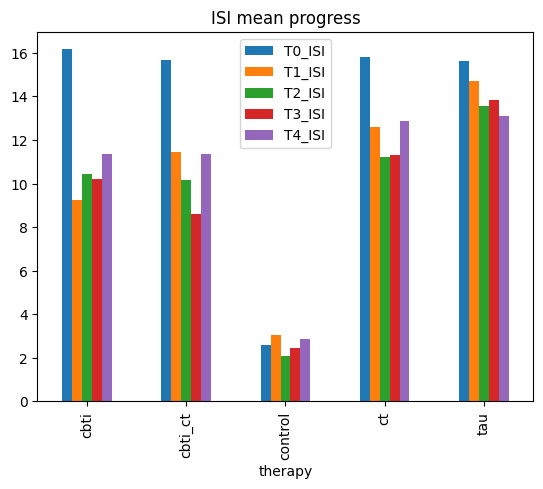

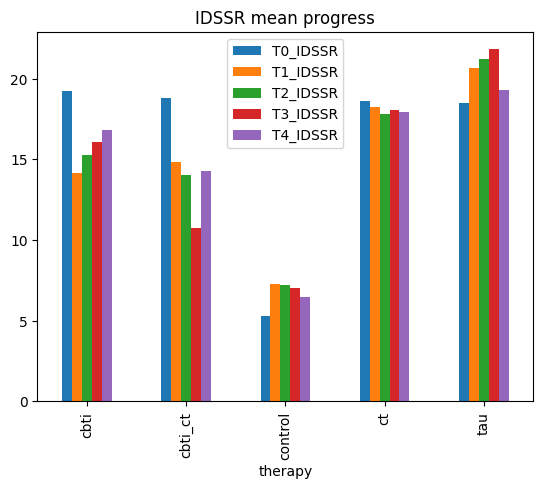

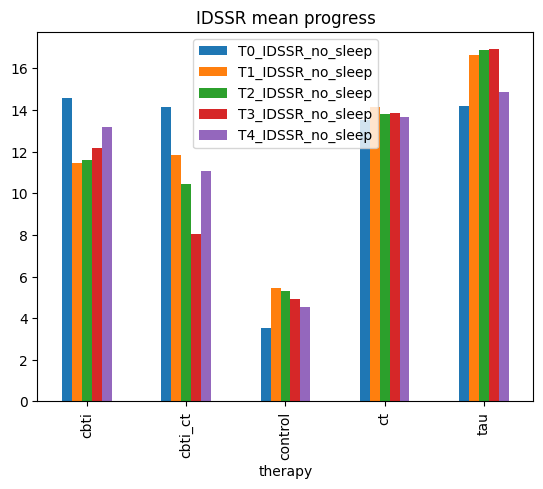

In [5]:
# Copy dataframe to add categorical vars (that are currently dummy coded)
# Change <name>.copy() 
descr = df_T0.copy()
# descr['therapy'] = df_no_dums['therapy']
# descr['subtype'] = df_no_dums['insomnia_subtype']
# descr['risk'] = df_no_dums['risk']
# descr = descr.drop(descr[descr['subtype'] == 5].index)


# Gender count
fig = px.histogram(descr, x="Male", nbins = 2, text_auto=True)
fig.update_layout(bargap=0.2, width=500, height=500
)
fig.show()

# Therapy condition count
fig = px.histogram(descr, x="therapy", nbins = 2, text_auto=True)
fig.update_layout(bargap=0.2, width=800, height=300)
fig.show()

fig = px.histogram(descr, x="Age", text_auto=True)
fig.update_layout(bargap=0.2, width=800, height=300)
fig.show()

# Risk group count
# fig = px.histogram(descr, x="risk", nbins = 2, text_auto=True)
# fig.update_layout(bargap=0.2, width=800, height=300)
# fig.show()

# # Insomnia subtype count
# fig = px.histogram(descr, x="subtype", text_auto=True)
# fig.update_layout(bargap=0.2, width=800, height=300)
# fig.show()

# Cumulative T1_IDSSR for age groups
fig = px.histogram(descr, x="Age", y="T1_IDSSR", text_auto=True)
fig.update_layout(bargap=0.2, width=800, height=300)
fig.show()

# Cumulative T1_IDSSR for gender 
fig = px.histogram(descr, x="Male", y="T1_IDSSR", text_auto=True)
fig.update_layout(bargap=0.2, width=800, height=300)
fig.show()

plt.style.use('default')

# Only works if T2,T3,T4 are included
df_mean = df_no_dums.groupby('therapy')['T0_ISI','T1_ISI','T2_ISI','T3_ISI','T4_ISI'].mean().reset_index()
df_mean.plot(x = 'therapy', y = ['T0_ISI','T1_ISI','T2_ISI','T3_ISI','T4_ISI'], kind = 'bar', title = 'ISI mean progress'),

df_mean = df_no_dums.groupby('therapy')['T0_IDSSR','T1_IDSSR','T2_IDSSR','T3_IDSSR','T4_IDSSR'].mean().reset_index()
df_mean.plot(x = 'therapy', y = ['T0_IDSSR','T1_IDSSR','T2_IDSSR','T3_IDSSR','T4_IDSSR'], kind = 'bar', title = 'IDSSR mean progress')

df_mean = df_no_dums.groupby('therapy')['T0_IDSSR_no_sleep','T1_IDSSR_no_sleep','T2_IDSSR_no_sleep','T3_IDSSR_no_sleep','T4_IDSSR_no_sleep'].mean().reset_index()
df_mean.plot(x = 'therapy', y = ['T0_IDSSR_no_sleep','T1_IDSSR_no_sleep','T2_IDSSR_no_sleep','T3_IDSSR_no_sleep','T4_IDSSR_no_sleep'], kind = 'bar', title = 'IDSSR mean progress')




**Raincloud plot**

Easy graph for insights on distribution, spread and boxplot.

Text(0.5, 1.0, 'Rainclouds')

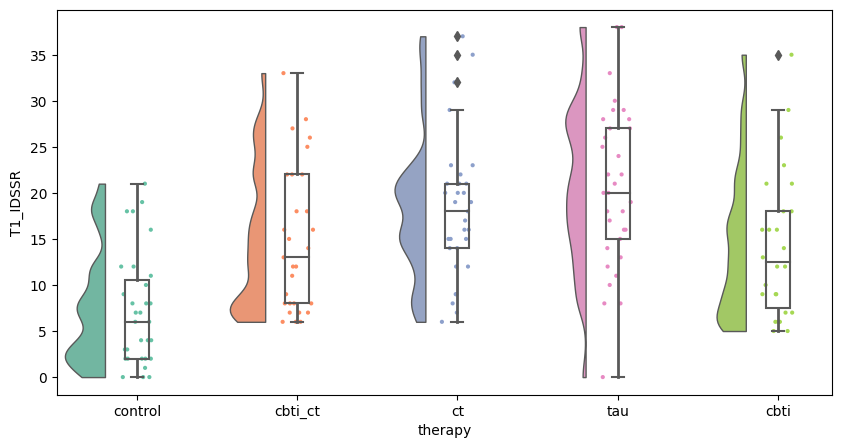

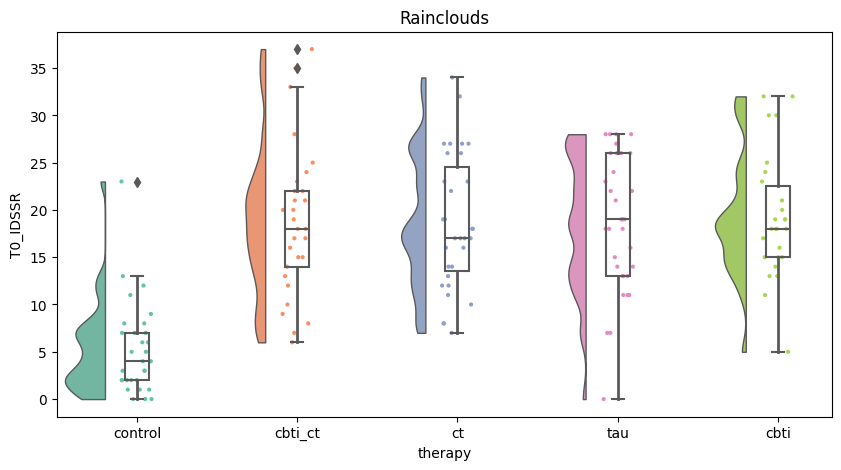

In [ ]:
plt.style.use('default')

# Raincloud graph for T1_IDSSR over therapy condition
dx="therapy"; dy="T1_IDSSR"; ort="v"; pal = "Set2"; sigma = .2
f, ax = plt.subplots(figsize=(10, 5))

ax=pt.RainCloud(x = dx, y = dy, data = df_no_dums, palette = pal, bw = sigma,
                 width_viol = .5, ax = ax, orient = ort, jitter = 1)


# Raincloud graph for T0_IDSSR over therapy condition
dx="therapy"; dy="T0_IDSSR"; ort="v"; pal = "Set2"; sigma = .2
f, ax = plt.subplots(figsize=(10, 5))

ax=pt.RainCloud(x = dx, y = dy, data = df_no_dums, palette = pal, bw = sigma,
                 width_viol = .5, ax = ax, orient = ort, jitter = 1)

plt.title("Rainclouds")


# Feature Selection

###**Building Principal Components Per Data Domain**
Problem: rule of thumb is around 10 samples per feature. Even with PCA there are 31 features and only 143 rows.

Explained variation PCA_FMRI_T0: [0.38163623 0.14466369 0.05800239 0.0497249  0.04114194 0.03834028
 0.0336724  0.03279146 0.03019475 0.02762256 0.02426988 0.02115829
 0.01816797]
Cumulative sum R2: [38.2 52.7 58.5 63.5 67.6 71.4 74.8 78.1 81.1 83.9 86.3 88.4 90.2]


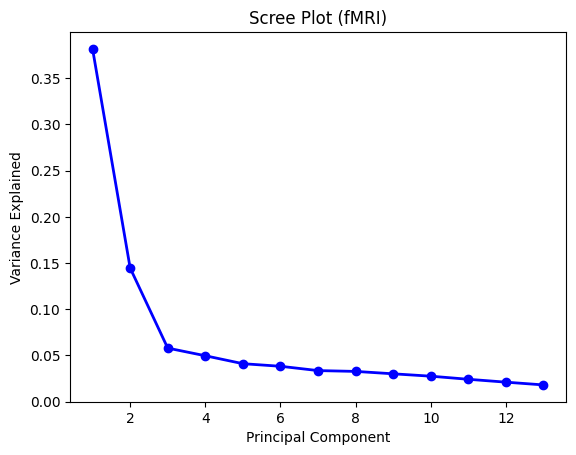

(115, 50)


(115, 50)
Explained variation PCA_DMRI_T0: [0.36594993 0.08066135 0.05321264 0.05126874 0.04460318 0.03888283
 0.03403014 0.02935533 0.02784118 0.02706245 0.02357137 0.02099051
 0.01768647 0.01572176 0.01467185 0.01404952 0.01214177 0.01125804
 0.00962353 0.00928843]
Cumulative sum R2: [36.6 44.7 50.  55.1 59.6 63.5 66.9 69.8 72.6 75.3 77.7 79.8 81.6 83.2
 84.7 86.1 87.3 88.4 89.4 90.3]


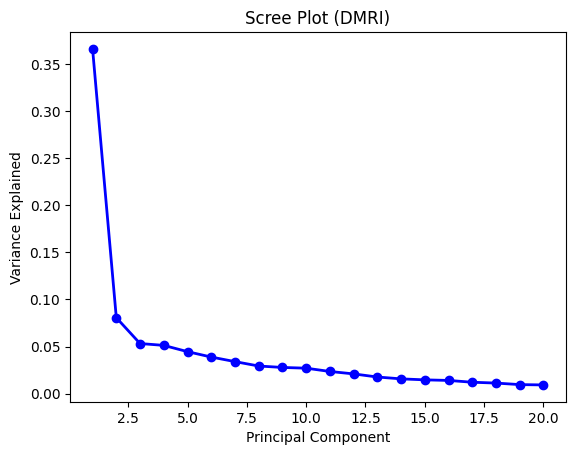

Explained variation PCA_Questionnaires_T0: [0.10129007 0.09224188 0.07272227 0.06055326 0.05115978 0.04917251
 0.04150681 0.03764674 0.03461909 0.02922896 0.02867809 0.02487947
 0.0237486  0.02165111 0.02059037 0.01949424 0.01917466 0.01801927
 0.01608666 0.01403197 0.01379163 0.01259247 0.01239006 0.01223751
 0.01170648 0.01065618 0.0097547  0.00968927 0.00910407 0.00816412
 0.00748616 0.00706006]
Cumulative sum R2: [10.1 19.3 26.6 32.7 37.8 42.7 46.9 50.7 54.2 57.1 60.  62.5 64.9 67.1
 69.2 71.1 73.  74.8 76.4 77.8 79.2 80.5 81.7 82.9 84.1 85.2 86.2 87.2
 88.1 88.9 89.6 90.3]


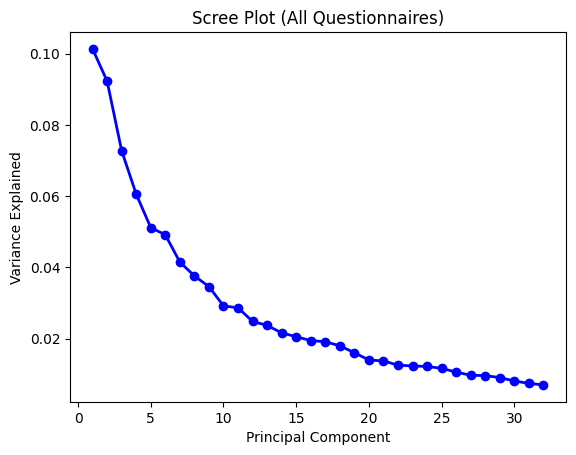

Explained variation PCA_ITQ_T0: [0.17511882 0.15006095 0.08409373 0.07226461 0.06455215 0.05802098
 0.04874598 0.04407844 0.03686717 0.0339469  0.03168588 0.02929174
 0.02520198 0.02473218 0.02088418 0.02011096]
Cumulative sum R2: [17.5 32.5 40.9 48.1 54.6 60.4 65.3 69.7 73.4 76.8 80.  82.9 85.4 87.9
 90.  92. ]


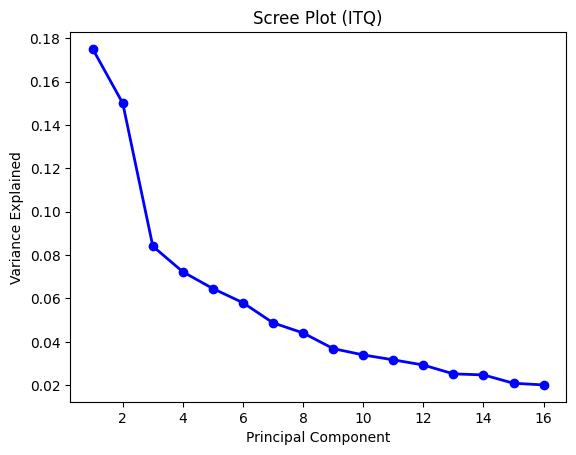

Explained variation PCA_CSD_T0: [0.14693606 0.12239492 0.08993938 0.0702847  0.06277062 0.05580582
 0.05261642 0.04150145 0.03438042 0.03227443 0.02728071 0.02532146
 0.02394427 0.0218907  0.02047441 0.01695672 0.01519557 0.01475872
 0.01322473 0.01142317 0.010666  ]
Cumulative sum R2: [14.7 26.9 35.9 42.9 49.2 54.8 60.1 64.3 67.7 70.9 73.6 76.1 78.5 80.7
 82.7 84.4 85.9 87.4 88.7 89.8 90.9]


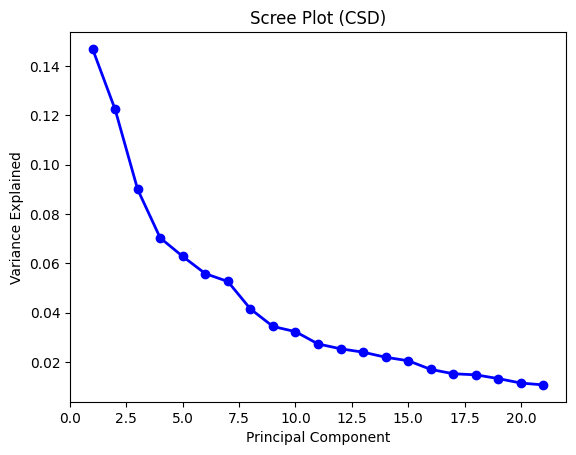

Explained variation PCA_ACT_T0: [0.2572147  0.1418964  0.10741489 0.09283732 0.05210302 0.05066842
 0.04373466 0.03983952 0.03441358 0.0299971  0.0266652  0.0234127 ]
Cumulative sum R2: [25.7 39.9 50.6 59.9 65.1 70.2 74.6 78.6 82.  85.  87.7 90. ]


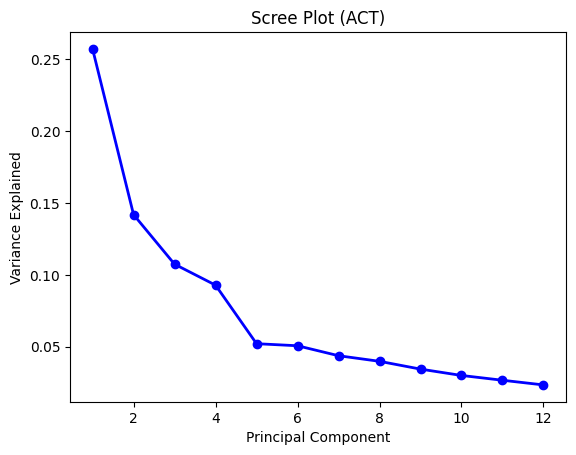

Explained variation PCA_ECG_T0: [0.38420699 0.17746548 0.14287412 0.11540428 0.0802    ]
Cumulative sum R2: [38.4 56.1 70.4 81.9 89.9]


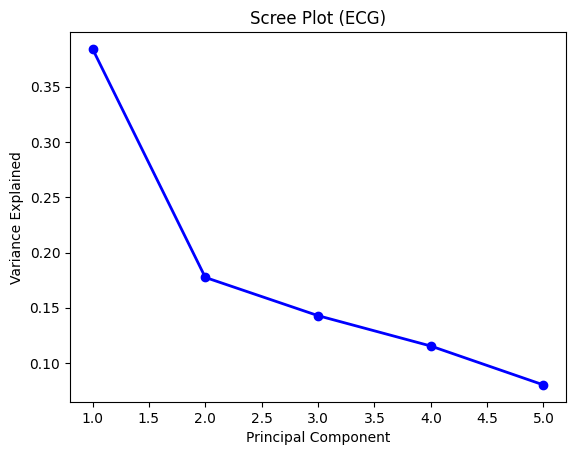

Explained variation PCA_EEG_T0: [0.24736323 0.16463162 0.14883045 0.08771166 0.08680963 0.05830561
 0.05317864 0.04347873 0.04030888]
Cumulative sum R2: [24.7 41.2 56.1 64.9 73.6 79.4 84.7 89.  93. ]


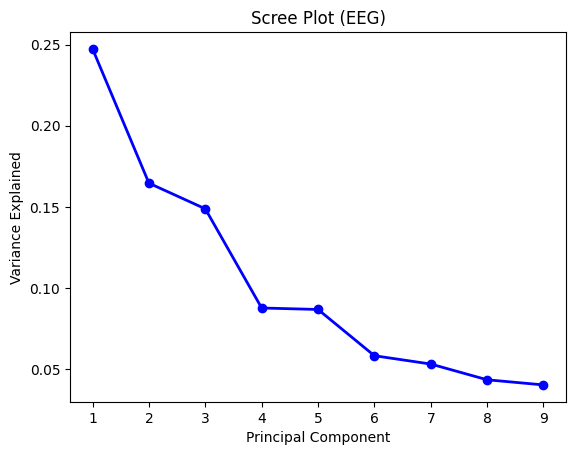

 PER DOMAIN COLLECTED FEATURES: 128 
PLOTTING HISTOGRAM AFTER SCALING


Explained variation PCA_all: [0.09988562 0.06956537 0.06435027 0.04533773 0.04081728 0.03484113
 0.03254632 0.02898652 0.02803755 0.02424279 0.02324556 0.02119934
 0.02016653 0.01967484]
Cumulative sum R2: [10.  17.  23.4 27.9 32.  35.5 38.8 41.7 44.5 46.9 49.2 51.3 53.3 55.3]


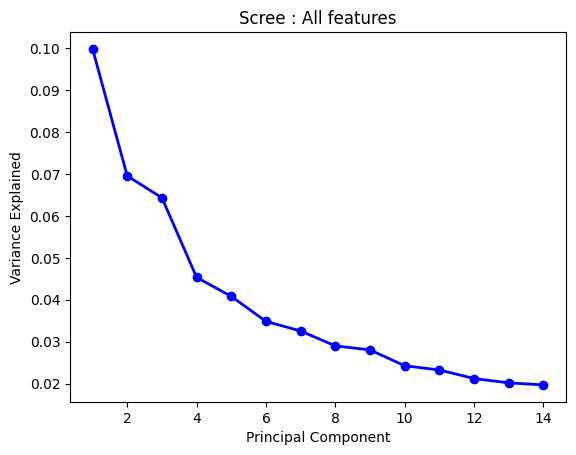

 FROM 241 FEATURES TO 14 FEATURES


In [6]:
scaler = StandardScaler()

# Initialize dataframe
pca_df = pd.DataFrame(columns=[])
pca_df_all = pd.DataFrame(columns=[])

# --------- Build PCA's for fMRI night, append to dataframe -----------
# SCALING
copied_fmri_T0 = fmri_T0.copy().drop('therapy',axis=1)
df_st =  StandardScaler().fit_transform(copied_fmri_T0)  
scaled_df_T0 = pd.DataFrame(df_st, columns=copied_fmri_T0.columns, index=copied_fmri_T0.index)
# fig = px.histogram(scaled_df_T0)
# fig.update_layout(bargap=0.2, width=1000, height=500
# )
# fig.show()

# PCA
pca_fmri_T0 = scaled_df_T0
pca_fmri = PCA(n_components=0.90)
pca_result = pca_fmri.fit_transform(pca_fmri_T0)
for i in range(0,pca_fmri.n_components_):
  pca_df[f'PCA_FMRI_T0_{i}'] = pca_result[:,i]
print('Explained variation PCA_FMRI_T0: {}'.format(pca_fmri.explained_variance_ratio_))
print('Cumulative sum R2: {}'.format(np.cumsum(np.round(pca_fmri.explained_variance_ratio_, decimals=3)*100)))

# PLOTTING 
PC_values = np.arange(pca_fmri.n_components_) + 1
plt.plot(PC_values, pca_fmri.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot (fMRI)')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

# --------- Build PCA's for DTI night, append to dataframe -----------
# SCALING
copied_dmri_T0 = dmri_T0.copy()
# display(copied_dmri_T0)
print(copied_dmri_T0.shape)

df_st =  StandardScaler().fit_transform(copied_dmri_T0)  
scaled_df_T0 = pd.DataFrame(df_st, columns=copied_dmri_T0.columns, index=copied_dmri_T0.index)
fig = px.histogram(scaled_df_T0)
fig.update_layout(bargap=0.2, width=1000, height=500
)
fig.show()

# PCA
pca_dmri_T0 = scaled_df_T0
print(scaled_df_T0.shape)
pca_dmri = PCA(n_components=0.90)
pca_result = pca_dmri.fit_transform(pca_dmri_T0)
for i in range(0,pca_dmri.n_components_):
  pca_df[f'PCA_DMRI_T0_{i}'] = pca_result[:,i]
print('Explained variation PCA_DMRI_T0: {}'.format(pca_dmri.explained_variance_ratio_))
print('Cumulative sum R2: {}'.format(np.cumsum(np.round(pca_dmri.explained_variance_ratio_, decimals=3)*100)))

# PLOTTING 
PC_values = np.arange(pca_dmri.n_components_) + 1
plt.plot(PC_values, pca_dmri.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot (DMRI)')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

# --------- Build PCA's for All QUESTIONNAIRES, append to dataframe -----------
extra_cols = ['T2_IDSSR','T3_IDSSR','T4_IDSSR','T0_IDSSR_no_sleep','T2_IDSSR_no_sleep','T3_IDSSR_no_sleep','T4_IDSSR_no_sleep','T2_ISI','T3_ISI','T4_ISI','T2_DIS','T2_DMA','T2_EMA','T3_DIS','T3_DMA','T3_EMA','T4_DIS','T4_DMA','T4_EMA','deterioration','improvement']

# SCALING
copied_q_T0 = q_T0.copy().drop(extra_cols,axis=1)
df_st =  StandardScaler().fit_transform(copied_q_T0)  
scaled_df_T0 = pd.DataFrame(df_st, columns=copied_q_T0.columns, index=copied_q_T0.index)

# PCA
pca_q_T0 = scaled_df_T0
pca_q = PCA(n_components=0.90)
pca_result = pca_q.fit_transform(pca_q_T0)
for i in range(0,pca_q.n_components_):
  pca_df[f'PCA_Questionnaires_T0_{i}'] = pca_result[:,i]
print('Explained variation PCA_Questionnaires_T0: {}'.format(pca_q.explained_variance_ratio_))
print('Cumulative sum R2: {}'.format(np.cumsum(np.round(pca_q.explained_variance_ratio_, decimals=3)*100)))

# PLOTTING
PC_values = np.arange(pca_q.n_components_) + 1
plt.plot(PC_values, pca_q.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot (All Questionnaires)')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

# --------- Build PCA's for ITQ, append to dataframe -----------
# SCALING
extra_cols = ['therapy_cbti','therapy_cbti_ct','improvement','deterioration','therapy']

copied_itq_T0 = itq_T0.copy().drop(extra_cols,axis=1)
df_st =  StandardScaler().fit_transform(copied_itq_T0)  
scaled_df_T0 = pd.DataFrame(df_st, columns=copied_itq_T0.columns, index=copied_itq_T0.index)

# PCA
pca_itq_T0 = scaled_df_T0
pca_itq = PCA(n_components=0.90)
pca_result = pca_itq.fit_transform(pca_itq_T0)
for i in range(0,pca_itq.n_components_):
  pca_df[f'PCA_ITQ_T0_{i}'] = pca_result[:,i]
print('Explained variation PCA_ITQ_T0: {}'.format(pca_itq.explained_variance_ratio_))
print('Cumulative sum R2: {}'.format(np.cumsum(np.round(pca_itq.explained_variance_ratio_, decimals=3)*100)))

# PLOTTING
PC_values = np.arange(pca_itq.n_components_) + 1
plt.plot(PC_values, pca_itq.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot (ITQ)')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

# --------- Build PCA's for CSD (SLEEP DIARY), append to dataframe -----------
# SCALING
copied_csd_T0 = csd_T0.copy().drop(extra_cols,axis=1)

df_st =  StandardScaler().fit_transform(copied_csd_T0)  
scaled_df_T0 = pd.DataFrame(df_st, columns=copied_csd_T0.columns, index=copied_csd_T0.index)

# PCA
pca_csd_T0 = scaled_df_T0
pca_csd = PCA(n_components=0.90)
pca_result = pca_csd.fit_transform(pca_csd_T0)
for i in range(0,pca_csd.n_components_):
  pca_df[f'PCA_CSD_T0_{i}'] = pca_result[:,i]
print('Explained variation PCA_CSD_T0: {}'.format(pca_csd.explained_variance_ratio_))
print('Cumulative sum R2: {}'.format(np.cumsum(np.round(pca_csd.explained_variance_ratio_, decimals=3)*100)))

# PLOTTING
PC_values = np.arange(pca_csd.n_components_) + 1
plt.plot(PC_values, pca_csd.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot (CSD)')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

# --------- Build PCA's for ACTIGRAPHY and append to dataframe -----------
# SCALING
copied_act_T0 = act_T0.copy().drop(extra_cols,axis=1)
copied_act_T0[:] = KNNImputer().fit_transform(copied_act_T0)
df_st =  StandardScaler().fit_transform(copied_act_T0)  
scaled_df_T0 = pd.DataFrame(df_st, columns=copied_act_T0.columns, index=copied_act_T0.index)

# PCA
pca_act_T0 = scaled_df_T0
pca_act = PCA(n_components=0.90)
pca_result = pca_act.fit_transform(pca_act_T0)
for i in range(0,pca_act.n_components_):
  pca_df[f'PCA_ACT_T0_{i}'] = pca_result[:,i]
print('Explained variation PCA_ACT_T0: {}'.format(pca_act.explained_variance_ratio_))
print('Cumulative sum R2: {}'.format(np.cumsum(np.round(pca_act.explained_variance_ratio_, decimals=3)*100)))

# PLOTTING
PC_values = np.arange(pca_act.n_components_) + 1
plt.plot(PC_values, pca_act.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot (ACT)')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

# --------- Build PCA's for ECG and append to dataframe -----------
extra_cols = ['therapy_cbti','therapy_cbti_ct','therapy']
# SCALING
copied_ecg_T0 = ecg_T0.copy().drop(extra_cols,axis=1)
copied_ecg_T0[:] = KNNImputer().fit_transform(copied_ecg_T0)

df_st =  StandardScaler().fit_transform(copied_ecg_T0)  
scaled_df_T0 = pd.DataFrame(df_st, columns=copied_ecg_T0.columns, index=copied_ecg_T0.index)

# PCA
pca_ecg_T0 = scaled_df_T0
pca_ecg = PCA(n_components=0.90)
pca_result = pca_ecg.fit_transform(pca_ecg_T0)
for i in range(0,pca_ecg.n_components_):
  pca_df[f'PCA_ECG_T0_{i}'] = pca_result[:,i]
print('Explained variation PCA_ECG_T0: {}'.format(pca_ecg.explained_variance_ratio_))
print('Cumulative sum R2: {}'.format(np.cumsum(np.round(pca_ecg.explained_variance_ratio_, decimals=3)*100)))

# PLOTTING
PC_values = np.arange(pca_ecg.n_components_) + 1
plt.plot(PC_values, pca_ecg.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot (ECG)')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

# --------- Build PCA's for HD-EEG and append to dataframe -----------


# SCALING
copied_eeg_T0 = sleep_T0.copy().drop(extra_cols,axis=1)
copied_eeg_T0[:] = KNNImputer().fit_transform(copied_eeg_T0)
df_st =  StandardScaler().fit_transform(copied_eeg_T0)  
scaled_df_T0 = pd.DataFrame(df_st, columns=copied_eeg_T0.columns, index=copied_eeg_T0.index)

# PCA
pca_eeg_T0 = scaled_df_T0
pca_eeg = PCA(n_components=0.90)
pca_result = pca_eeg.fit_transform(pca_eeg_T0)
for i in range(0,pca_eeg.n_components_):
  pca_df[f'PCA_EEG_T0_{i}'] = pca_result[:,i]
print('Explained variation PCA_EEG_T0: {}'.format(pca_eeg.explained_variance_ratio_))
print('Cumulative sum R2: {}'.format(np.cumsum(np.round(pca_eeg.explained_variance_ratio_, decimals=3)*100)))

# PLOTTING
PC_values = np.arange(pca_eeg.n_components_) + 1
plt.plot(PC_values, pca_eeg.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot (EEG)')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()


print('=====================\n PER DOMAIN COLLECTED FEATURES: {} \n======================'.format(len(pca_df.columns)))

# --------- Build PCA's for ALL T0 DATA and append to dataframe -----------

# SCALING
extra_cols = ['subject','T2_IDSSR','T3_IDSSR','T4_IDSSR','T0_IDSSR_no_sleep','T2_IDSSR_no_sleep','T3_IDSSR_no_sleep','T4_IDSSR_no_sleep','T2_ISI','T3_ISI','T4_ISI','therapy','T1_IDSSR_no_sleep','deterioration','improvement','T2_DIS','T2_DMA','T2_EMA','T3_DIS','T3_DMA','T3_EMA','T4_DIS','T4_DMA','T4_EMA']

copied_df_T0 = df_T0.copy().drop(extra_cols,axis=1)
copied_df_T0[:] = KNNImputer().fit_transform(copied_df_T0)

df_st =  StandardScaler().fit_transform(copied_df_T0)  
scaled_df_T0 = pd.DataFrame(df_st, columns=copied_df_T0.columns, index=copied_df_T0.index)
scaled_df_T0.merge(fmri_T0)


# PLOTTING HISTOGRAM
print('PLOTTING HISTOGRAM AFTER SCALING')
fig = px.histogram(scaled_df_T0)
fig.update_layout(bargap=0.2, width=1000, height=500
)
fig.show()



# PCA
pca_all = scaled_df_T0
pca = PCA(n_components=14)
pca_result = pca.fit_transform(pca_all)
for i in range(0,pca.n_components_):
  pca_df_all[f'PCA_{i}'] = pca_result[:,i]
print('Explained variation PCA_all: {}'.format(pca.explained_variance_ratio_))
print('Cumulative sum R2: {}'.format(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)))

# PLOTTING
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree : All features')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

print('=====================\n FROM {} FEATURES TO {} FEATURES\n======================'.format(len(df_T0.columns),len(pca_df_all.columns)))
# print('=====================\n ALL IN ONE COLLECTED FEATURES: {} \n======================'.format(len(pca_df_all.columns)))



pca_components = pca.components_.T
pca_r2 = pca.explained_variance_
pca_r2_ratio = pca.explained_variance_ratio_
components = pca_result




#### PCA Loadings
`Loadings = eigenvectors \ sqrt(eigenvalues)`

The matrix below shows the loadings of the PCA.
Each entry of the matrix contains the **correlation between the original variable and the principal component**. For example, 




In [7]:
#--------------------------------------------------------------------------------------------------
# CALCULATE LOADINGS, BASIC VERSION THAT SORTS BY PCA_0

loadings = pca_components * np.sqrt(pca_r2)

columns = [column for column in pca_df_all.columns]

loadings = pd.DataFrame(
    loadings.round(2),
    columns=columns,
    index=pca_all.columns,
).abs()

loadings.index.name = "Variables"
loadings = loadings.sort_values(by=['PCA_0'],ascending=False)

# display(loadings)

#--------------------------------------------------------------------------------------------------

# MAKE A DICTIONARY OF ALL LOADINGS PER PCA. THIS IS TO SORT THEM AND CALCULATE SMALLEST AND LARGEST


pca_dict = {}
pca_largest_dict = {}
pca_smallest_dict = {}
for i in range(0,loadings.columns.size):
    data_pca = pd.DataFrame(loadings[f'PCA_{i}']).sort_values(by=[f'PCA_{i}'],ascending=False)
    data_pca.index.name = 'Variables'
    pca_dict["pca_" + str(i)] = data_pca.reset_index()
    pca_largest_dict["pca_" + str(i)] = pca_dict[f"pca_{i}"].nlargest(n=5, columns=[f'PCA_{i}'])
    pca_smallest_dict["pca_" + str(i)] = pca_dict[f"pca_{i}"].nsmallest(n=5, columns=[f'PCA_{i}'])

# display(pca_smallest_dict['pca_0'])
# display(pca_largest_dict['pca_0'])
# for i in range()
for i in range(0,pca_r2_ratio.size):
    print(f'==== EXPLAINED VARIANCE OF PCA {i} ====')
    print(pca_r2_ratio[i])
    display(pca_dict[f'pca_{i}'].head(5))
    print('\n')


# display(pca_dict)

#--------------------------------------------------------------------------------------------------

# CONCATENATE ALL VARIABLES TO ASSESS WHICH VARIABLES OCCUR MOST.
concat_vars = pd.DataFrame()
for key in pca_largest_dict.keys():
    concat_vars = pd.concat([concat_vars, pca_largest_dict[f'{key}']['Variables']])

# EXTRACT TOP n OCCURRING VARIABLES
subset = concat_vars[0].value_counts().to_frame()
subset = subset[:10].index.values.tolist()
df_occurences = df_T0[subset]
df_occurences['T1_IDSSR_no_sleep'] = target['T1_IDSSR_no_sleep']
# display(df_occurences[:10])


#--------------------------------------------------------------------------------------------------

# SUM ALL VARIABLES TOTAL CONTRIBUTION. note: look for negatives as well.
complete_pca = loadings.copy().reset_index()
complete_pca.insert(0, 'sum', complete_pca.sum(axis=1) )

# display(complete_pca[['Variables','sum']].sort_values(by=['sum'],ascending=False).head(20))
# display(complete_pca[['Variables','sum']].sort_values(by=['sum'],ascending=True).head(20))

# smallest_sum = complete_pca.nsmallest(n=7, columns=['sum'])
largest_sum = complete_pca.nlargest(n=14, columns=['sum'])

# smallest_vars = smallest_sum['Variables'].tolist()
largest_vars = largest_sum['Variables'].tolist()
# extreme_vars = smallest_vars + largest_vars

# df_extremes[baseline] = df[baseline]
# df_extremes[largest_vars] = df_T0[largest_vars]
# df_extremes['T1_IDSSR'] = df['T1_IDSSR']

# display(df_extremes[:14])
# display(smallest_sum) 
# display(largest_sum)          

#--------------------------------------------------------------------------------------------------
# add T1 idssr to pca all
# pca_df_all['T1_IDSSR_no_sleep'] = df['T1_IDSSR_no_sleep']



### Note: Loadings are basically how similar some factors are in a certain principal component. If a variable has a high loading, it correlates well with other variables in that component.
### High loading variables are not copies of eachother, but have their own unique relationship with other variables. 
### The idea is to take the top loadings per PC and add them to the feature set.

==== EXPLAINED VARIANCE OF PCA 0 ====
0.09988561796139875


,Variables,PCA_0
0,mean_skel,0.91
1,no_label_skel,0.85
2,Sagittal_stratum_(include_inferior_longitidina...,0.77
3,Anterior_corona_radiata_R,0.74
4,Genu_of_corpus_callosum,0.74




==== EXPLAINED VARIANCE OF PCA 1 ====
0.06956537107533066


,Variables,PCA_1
0,T0_vis_limb,0.66
1,T0_dors_limb,0.65
2,T0_vis_fp,0.64
3,T0_mean_Mid_Sleep_Time_Dec_Hr,0.64
4,T0_som_dors,0.63




==== EXPLAINED VARIANCE OF PCA 2 ====
0.06435026828721098


,Variables,PCA_2
0,T0_som_def,0.59
1,T0_vent_def,0.57
2,T0_sd_CSDM_SOW_Recalc,0.56
3,T0_som_vent,0.56
4,T0_vent_limb,0.55




==== EXPLAINED VARIANCE OF PCA 3 ====
0.045337730495697996


,Variables,PCA_3
0,T0_mean_CSDM_SOW_Recalc,0.71
1,T0_mean_SOW,0.70
2,T0_mean_TIB,0.65
3,T0_mean_CSDM_TIB_Recalc,0.63
4,T0_mean_SleepOpEnd_Dec_Hr,0.60




==== EXPLAINED VARIANCE OF PCA 4 ====
0.040817278807311334


,Variables,PCA_4
0,T0_mean_CSDM_TST_Recalc,0.83
1,T0_mean_CSDM_SEsow_Recalc,0.71
2,T0_sd_CSDM_SEsow_Recalc,0.66
3,T0_mean_CSDM_SEtib_Recalc,0.65
4,T0_sd_CSDM_SEtib_Recalc,0.62




==== EXPLAINED VARIANCE OF PCA 5 ====
0.03484112717156896


,Variables,PCA_5
0,T0_Z_AmygdalaL_mean,0.62
1,T0_Z_AmygdalaL_median,0.61
2,T0_Z_AmygdalaL_max,0.54
3,T0_Z_AmygdalaR_mean,0.52
4,T0_Z_AmygdalaR_max,0.52




==== EXPLAINED VARIANCE OF PCA 6 ====
0.03254631963207877


,Variables,PCA_6
0,SCRN_ITQ_ACS_score,0.45
1,T0_mean_CSD_WellRested,0.39
2,SCRN_ITQ_PI_rumination,0.39
3,N3_perc,0.37
4,Sdnn_wake,0.36




==== EXPLAINED VARIANCE OF PCA 7 ====
0.028986522447136738


,Variables,PCA_7
0,Superior_cerebellar_peduncle_L,0.53
1,T0_mean_Bedtime_Dec_Hr,0.48
2,Superior_cerebellar_peduncle_R,0.46
3,T0_mean_CSD_Bedtime_Dec_Hr,0.45
4,T0_Z_AmygdalaR_mean,0.44




==== EXPLAINED VARIANCE OF PCA 8 ====
0.02803754525908332


,Variables,PCA_8
0,HFnu_24,0.48
1,T0_sd_CSD_LogSOL_and_1,0.47
2,T0_sd_CSD_SOL_min,0.47
3,T0_sd_CSD_Qualit,0.43
4,HFnu_wake,0.43




==== EXPLAINED VARIANCE OF PCA 9 ====
0.024242790715495715


,Variables,PCA_9
0,Male,0.50
1,SCRN_ITQ_PI_score_R,0.44
2,SCRN_ITQ_PI_perceived_parental_pressure,0.43
3,T0_Z_AmygdalaR_median,0.40
4,T0_Z_AmygdalaR_mean,0.38




==== EXPLAINED VARIANCE OF PCA 10 ====
0.02324555846892101


,Variables,PCA_10
0,SCRN_ITQ_RRS_score,0.45
1,HFnu_24,0.40
2,HFnu_sleep,0.39
3,SCRN_ITQ_PI_rumination,0.36
4,Fornix_(column_and_body_of_fornix),0.35




==== EXPLAINED VARIANCE OF PCA 11 ====
0.021199342578381013


,Variables,PCA_11
0,T0_sd_CSD_Thoughts,0.48
1,T0_sd_CSD_Bedtime_Worry,0.43
2,Middle_cerebellar_peduncle,0.42
3,T0_sd_CSD_Thoughts_Dreams,0.39
4,T0_mean_CSD_Thoughts,0.38




==== EXPLAINED VARIANCE OF PCA 12 ====
0.020166534491317698


,Variables,PCA_12
0,T0_sd_CSD_WellRested,0.47
1,T0_sd_CSD_OvernightSleepinessChange,0.39
2,T0_mean_CSD_logWASO_num_and_1,0.35
3,T0_mean_CSD_WASO_num,0.34
4,HR_wake,0.33




==== EXPLAINED VARIANCE OF PCA 13 ====
0.019674839345565628


,Variables,PCA_13
0,R_delay,0.39
1,HR_24,0.39
2,T0_ISI,0.38
3,HR_wake,0.37
4,HR_sleep,0.33


## **Feature Ranking: SelectKBest**

A feature scoring system that takes score functions. 


*   Some SelectKBest functions require MinMaxScaler, uncomment if needed.

*   SelectKBest requires no NaN values. Used K Nearest Neighbors. However we have so many NaN values that this method is probably not so efficient.

In [10]:
#--------------------------------------------------------------------------------------------------
# Impute using K Nearest Neighbors. 
# df.replace([np.inf, -np.inf], np.nan, inplace=True)
# df = df.fillna(df.mean()) # somehow, some na's survive, just impute these one or two with mean

#  = df.copy().drop("T1_IDSSR",axis=1)

# X_kbest = df_T0[df.columns.drop(list(df.filter(regex='T1|subject|subtype|risk')))].drop(['T0_IDSSR','subject'],axis=1)
# y_kbest = df.copy().pop('T1_IDSSR_no_sleep')
extra_cols = ['T2_IDSSR','T3_IDSSR','T4_IDSSR','T0_IDSSR_no_sleep','T2_IDSSR_no_sleep','T3_IDSSR_no_sleep','T4_IDSSR_no_sleep','T2_ISI','T3_ISI','T4_ISI','therapy','T1_IDSSR_no_sleep','deterioration','T2_DIS','T2_DMA','T2_EMA','T3_DIS','T3_DMA','T3_EMA','T4_DIS','T4_DMA','T4_EMA']
X_kbest = df_T0.drop(extra_cols,axis=1)

# QUICK EXPORT FOR JAMOVI POST-ANALYSIS
X_kbest.to_csv('data_featureselection.csv')
print(X_kbest.shape)
y_kbest = X_kbest.pop('T1_IDSSR')
y_cat_kbest = X_kbest.pop('improvement')
X_kbest[:] = KNNImputer().fit_transform(X_kbest)
X_kbest_mif = X_kbest.copy()


#--------------------------------------------------------------------------------------------------
# F_REGRESSION

# print("Feature data dimension: ", X_kbest.shape) 
# print(y_kbest.shape)
# print(y_cat_kbest.shape)

select = SelectKBest(score_func= f_regression, k=14)
z = select.fit(X_kbest,y_kbest)
mask = select.get_support()
new_features = X_kbest.columns[mask]

f_df = pd.DataFrame(index = new_features, columns=['F_statistic','P_value'])
f_df['F_statistic'] = z.scores_[mask].round(2)
f_df['P_value'] = z.pvalues_[mask].round(3)
display(f_df)
# display(f_df['F_statistic'].values)
# display(f_df['P_value'].values)
# display(z.scores_)

filter = select.get_support()
features = X_kbest.columns
 
pd.set_option('max_columns', None)
pd.set_option("max_rows", None)
# display(features)
# print("Selected best 10:")
# display(features[filter])
f_features = features[filter]
# display(df_T0)
#--------------------------------------------------------------------------------------------------
# MAKE CORRELATION MATRIX, EXTRACT IN A READABLE MANNER

# corrMatrix = X_kbest[features[filter]].corr()
# plt.figure(figsize = (20,7))
# # sns.heatmap(corrMatrix, annot=True)

# upper_corr_mat = corrMatrix.where(
#     np.triu(np.ones(corrMatrix.shape), k=1).astype(np.bool))
  
# # Convert to 1-D series and drop Null values
# unique_corr_pairs = upper_corr_mat.unstack().dropna()
  
# # Sort correlation pairs
# sorted_mat = unique_corr_pairs.sort_values().round(2)

# sorted_mat = pd.DataFrame(sorted_mat)
# display(sorted_mat)


#--------------------------------------------------------------------------------------------------
# MUTUAL_INFO_REGRESSION
from sklearn.feature_selection import mutual_info_regression

# print("Feature data dimension: ", X_kbest_mif.shape) 
# print(y_kbest.shape)
# print(y_cat_kbest.shape)

select = SelectKBest(score_func= mutual_info_regression, k=14)
z = select.fit(X_kbest_mif,y_kbest)
mask = select.get_support()
new_features = X_kbest_mif.columns[mask]


mif_df = pd.DataFrame(index = new_features)

print('==== Mutual information between two random variables is a non-negative value,which measures the dependency between the variables.\n It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency. ===')
mif_df['Mutual Information'] = z.scores_[mask].round(2)
# mif_df['P_value'] = z.pvalues_[mask].round(3)
display(mif_df)

# print(select.scores_[:10])
# print(z.pvalues_)
# print(select.feature_names_in_[mask])

filter = select.get_support()
features = X_kbest_mif.columns
 
pd.set_option('max_columns', None)
pd.set_option("max_rows", None)

# display(features[filter])

mif_features = features[filter]


#--------------------------------------------------------------------------------------------------
# MAKE CORRELATION MATRIX, EXTRACT IN A READABLE MANNER

# corrMatrix = X_kbest_mif[features[filter]].corr()
# plt.figure(figsize = (20,7))
# # sns.heatmap(corrMatrix, annot=True)

# upper_corr_mat = corrMatrix.where(
#     np.triu(np.ones(corrMatrix.shape), k=1).astype(np.bool))
  
# # Convert to 1-D series and drop Null values
# unique_corr_pairs = upper_corr_mat.unstack().dropna()
  
# # Sort correlation pairs
# sorted_mat = unique_corr_pairs.sort_values().round(2)

# sorted_mat = pd.DataFrame(sorted_mat)
# display(sorted_mat)




(115, 219)


,F_statistic,P_value
T0_IDSSR,32.00,0.000
T0_ISI,4.45,0.037
T0_mean_EyesClosed_Dec_Hr,5.28,0.023
T0_sd_Getuptime_Dec_Hr,11.39,0.001
T0_sd_Cr_of_Grav_Temp_Dec_Hr,7.95,0.006
SCRN_ITQ_SHS_score,11.88,0.001
SCRN_ITQ_RRS_score,11.53,0.001
SCRN_ITQ_MIPIP_neuroticism,9.41,0.003
SCRN_ITQ_PANAS_negative_affect,16.74,0.000
SCRN_ITQ_FSS_score,13.73,0.000


==== Mutual information between two random variables is a non-negative value,which measures the dependency between the variables.
 It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency. ===


,Mutual Information
T0_IDSSR,0.15
T0_mean_EyesClosed_Dec_Hr,0.10
SCRN_ITQ_MIPIP_neuroticism,0.17
SCRN_ITQ_PANAS_negative_affect,0.14
SCRN_ITQ_PI_organization,0.09
SCRN_ITQ_FSS_score,0.11
T0_sd_CSDM_SEsow_Recalc,0.09
T0_sd_CSD_OvernightSleepinessChange,0.09
T0_som_def,0.11
Medial_lemniscus_R,0.11


## **Recursive Feature Elimination with Cross-Validation (RFECV)**

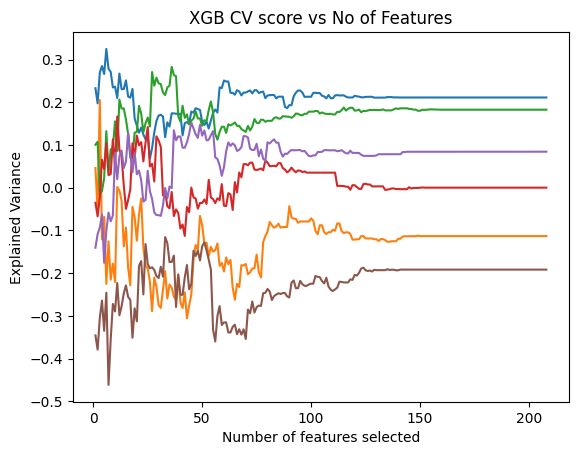

In [11]:
from sklearn.feature_selection import RFECV 
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import StratifiedKFold

extra_cols = ['T1_IDSSR_no_sleep','T2_IDSSR','T3_IDSSR','T4_IDSSR','T0_IDSSR_no_sleep','T2_IDSSR_no_sleep','T3_IDSSR_no_sleep','T4_IDSSR_no_sleep','T2_ISI','T3_ISI','T4_ISI','therapy','deterioration','improvement','T2_DIS','T2_DMA','T2_EMA','T3_DIS','T3_DMA','T3_EMA','T4_DIS','T4_DMA','T4_EMA']

# display(df_T0)

X = df_T0.drop(extra_cols, axis=1)
y = X.pop('T1_IDSSR')
X[:] = KNNImputer().fit_transform(X_kbest)

regressor = XGBRegressor(objective = 'reg:squarederror')
feature_selector = RFECV(regressor, step=1, min_features_to_select=10,cv=6, scoring='explained_variance')

fit = feature_selector.fit(X,y)


plt.figure()
plt.title('XGB CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Explained Variance")
plt.plot(range(1, len(fit.grid_scores_) + 1), fit.grid_scores_)
plt.show()



In [ ]:
display(X.head())

,subject,Male,Age,T0_IDSSR,T0_ISI,T0_DIS,T0_DMA,T0_EMA,HR_sleep,HR_wake,HR_24,HFnu_wake,HFnu_sleep,HFnu_24,Sdnn_wake,Sdnn_24,Rmssd_wake,Rmssd_sleep,Rmssd_24,T0_mean_TST_TIB,T0_mean_TIB,T0_mean_SE_TIB,T0_mean_SOW,T0_mean_TST_SOW,T0_mean_Awakenings_TIB,T0_mean_Mean_Temp,T0_mean_Bedtime_Dec_Hr,T0_mean_EyesClosed_Dec_Hr,T0_mean_SleepOpEnd_Dec_Hr,T0_mean_Getuptime_Dec_Hr,T0_mean_Mid_Sleep_Time_Dec_Hr,T0_mean_Cr_of_Grav_Temp_Dec_Hr,T0_mean_Cr_of_Grav_to_Mid_Sleep_Delay_Dec_Hr,T0_sd_TST_TIB,T0_sd_TIB,T0_sd_SE_TIB,T0_sd_SOW,T0_sd_TST_SOW,T0_sd_Awakenings_TIB,T0_sd_Mean_Temp,T0_sd_Bedtime_Dec_Hr,T0_sd_EyesClosed_Dec_Hr,T0_sd_SleepOpEnd_Dec_Hr,T0_sd_Getuptime_Dec_Hr,T0_sd_Mid_Sleep_Time_Dec_Hr,T0_sd_Cr_of_Grav_Temp_Dec_Hr,T0_sd_Cr_of_Grav_to_Mid_Sleep_Delay_Dec_Hr,SCRN_ITQ_ACS_score,SCRN_ITQ_BAS_score,SCRN_ITQ_SHS_score,SCRN_ITQ_RPA_positive_rumination,SCRN_ITQ_RPA_dampening,SCRN_ITQ_RRS_score,SCRN_ITQ_MIPIP_extraversion,SCRN_ITQ_MIPIP_neuroticism,SCRN_ITQ_MIPIP_agreeableness,SCRN_ITQ_PANAS_negative_affect,SCRN_ITQ_PANAS_positive_affect,SCRN_ITQ_TEPS_score,SCRN_ITQ_PI_organization,SCRN_ITQ_PI_perceived_parental_pressure,SCRN_ITQ_PI_rumination,SCRN_ITQ_PI_score_R,SCRN_ITQ_FIRST_score,SCRN_ITQ_PSAS_score,SCRN_ITQ_FSS_score,SCRN_ITQ_CTQ_score,T0_mean_CSDM_TIB_Recalc,T0_mean_CSDM_SOW_Recalc,T0_mean_CSDM_TST_Recalc,T0_mean_CSDM_SEtib_Recalc,T0_mean_CSDM_SEsow_Recalc,T0_mean_CSD_Bedtime_Dec_Hr,T0_mean_CSD_EyesClosed_Dec_Hr,T0_mean_CSD_SleepOpEnd_Dec_Hr,T0_mean_CSD_SOL_min,T0_mean_CSD_LogSOL_and_1,T0_mean_CSD_WASO_num,T0_mean_CSD_logWASO_num_and_1,T0_mean_CSD_WASO_min,T0_mean_CSD_logWASO_min_and_1,T0_mean_CSD_EMA_min,T0_mean_logCSD_EMA_min_and_1,T0_mean_CSD_Getuptime_Dec_Hr,T0_mean_CSD_Mid_Sleep_Time_Dec_Hr,T0_mean_CSD_Qualit,T0_mean_CSD_WellRested,T0_mean_CSD_BedtimeSleepiness,T0_mean_CSD_OvernightSleepinessChange,T0_mean_CSD_Bedtime_Worry,T0_mean_CSD_Thoughts,T0_mean_CSD_Dreams,T0_mean_CSD_Thoughts_Dreams,T0_mean_CSD_Nap,T0_sd_CSDM_TIB_Recalc,T0_sd_CSDM_SOW_Recalc,T0_sd_CSDM_TST_Recalc,T0_sd_CSDM_SEtib_Recalc,T0_sd_CSDM_SEsow_Recalc,T0_sd_CSD_Bedtime_Dec_Hr,T0_sd_CSD_EyesClosed_Dec_Hr,T0_sd_CSD_SleepOpEnd_Dec_Hr,T0_sd_CSD_SOL_min,T0_sd_CSD_LogSOL_and_1,T0_sd_CSD_WASO_num,T0_sd_CSD_logWASO_num_and_1,T0_sd_CSD_WASO_min,T0_sd_CSD_logWASO_min_and_1,T0_sd_CSD_EMA_min,T0_sd_logCSD_EMA_min_and_1,T0_sd_CSD_Getuptime_Dec_Hr,T0_sd_CSD_Mid_Sleep_Time_Dec_Hr,T0_sd_CSD_Qualit,T0_sd_CSD_WellRested,T0_sd_CSD_BedtimeSleepiness,T0_sd_CSD_OvernightSleepinessChange,T0_sd_CSD_Bedtime_Worry,T0_sd_CSD_Thoughts,T0_sd_CSD_Dreams,T0_sd_CSD_Thoughts_Dreams,T0_sd_CSD_Nap,sleep_period_dur,N1_perc,N2_perc,N3_perc,R_perc,WASO_perc,N2_delay,N3_delay,R_delay,stage_change_dens,NR_frag_dens,NRasc_frag_dens,R_frag_dens,diff_ISI_T0_1,diff_DIS_T0_1,diff_DMA_T0_1,diff_EMA_T0_1,therapy_cbti,therapy_cbti_ct,T0_Z_AmygdalaL_nvoxels,T0_Z_AmygdalaL_min,T0_Z_AmygdalaL_mean,T0_Z_AmygdalaL_median,T0_Z_AmygdalaL_max,T0_Z_AmygdalaR_nvoxels,T0_Z_AmygdalaR_min,T0_Z_AmygdalaR_mean,T0_Z_AmygdalaR_median,T0_Z_AmygdalaR_max,T0_vis_som,T0_vis_dors,T0_vis_vent,T0_vis_limb,T0_vis_fp,T0_vis_def,T0_som_dors,T0_som_vent,T0_som_limb,T0_som_fp,T0_som_def,T0_dors_vent,T0_dors_limb,T0_dors_fp,T0_dors_def,T0_vent_limb,T0_vent_fp,T0_vent_def,T0_limb_fp,T0_limb_def,T0_fp_def,mean_skel,no_label_skel,Middle_cerebellar_peduncle,Pontine_crossing_tract_(a_part_of_MCP),Genu_of_corpus_callosum,Body_of_corpus_callosum,Splenium_of_corpus_callosum,Fornix_(column_and_body_of_fornix),Corticospinal_tract_R,Corticospinal_tract_L,Medial_lemniscus_R,Medial_lemniscus_L,Inferior_cerebellar_peduncle_R__,Inferior_cerebellar_peduncle_L,Superior_cerebellar_peduncle_R,Superior_cerebellar_peduncle_L,Cerebral_peduncle_R,Cerebral_peduncle_L,Anterior_limb_of_internal_capsule_R,Anterior_limb_of_internal_capsule_L,Posterior_limb_of_internal_capsule_R,Posterior_limb_of_internal_capsule_L,Retrolenticular_part_of_internal_capsule_R,Retrolenticular_part_of_internal_capsule_L,Anterior_corona_radiata_R,Anterior_corona_radiata_L,Superior_coron

In [12]:
# print("Optimum number of features: %d" % feature_selector.n_features_)
# print("Survived features: {}".format(X.columns[feature_selector.support_]))
# print("Ranking: {}".format(feature_selector.ranking_))

rfecv_features = pd.DataFrame(columns = ['feature', 'support', 'ranking'])

# selected_features = feature_selector.get_support(1)
columns = X.columns[feature_selector.support_]

display(columns)
print(columns.shape[0])

for i in range(X.shape[1]):
    row = {'feature': X.columns[i], 'support': feature_selector.support_[i], 'ranking': feature_selector.ranking_[i]}
    rfecv_features = rfecv_features.append(row, ignore_index=True)
    
rfecv_features.sort_values(by='ranking').head(10)

rfecv_features = rfecv_features[rfecv_features['support']==True].reset_index(drop=True)
display(rfecv_features)

corrMatrix = X[columns].corr()
plt.figure(figsize = (20,7))
# sns.heatmap(corrMatrix, annot=True)

upper_corr_mat = corrMatrix.where(
    np.triu(np.ones(corrMatrix.shape), k=1).astype(np.bool))
  
# Convert to 1-D series and drop Null values
unique_corr_pairs = upper_corr_mat.unstack().dropna()
  
# Sort correlation pairs
sorted_mat = unique_corr_pairs.sort_values().round(2)

sorted_mat = pd.DataFrame(sorted_mat)


Index(['T0_IDSSR', 'T0_mean_Cr_of_Grav_Temp_Dec_Hr', 'SCRN_ITQ_SHS_score',
       'SCRN_ITQ_RRS_score', 'SCRN_ITQ_MIPIP_neuroticism',
       'SCRN_ITQ_FSS_score', 'T0_mean_CSD_logWASO_min_and_1',
       'T0_mean_CSD_EMA_min', 'T0_mean_logCSD_EMA_min_and_1',
       'T0_mean_CSD_Dreams', 'T0_sd_CSD_logWASO_num_and_1',
       'T0_sd_CSD_Getuptime_Dec_Hr', 'T0_Z_AmygdalaL_min',
       'T0_Z_AmygdalaL_median', 'T0_Z_AmygdalaR_max', 'T0_som_vent',
       'mean_skel', 'Superior_cerebellar_peduncle_L', 'Uncinate_fasciculus_R',
       'Uncinate_fasciculus_L', 'Tapetum_R'],
      dtype='object')

21


,feature,support,ranking
0,T0_IDSSR,True,1
1,T0_mean_Cr_of_Grav_Temp_Dec_Hr,True,1
2,SCRN_ITQ_SHS_score,True,1
3,SCRN_ITQ_RRS_score,True,1
4,SCRN_ITQ_MIPIP_neuroticism,True,1
5,SCRN_ITQ_FSS_score,True,1
6,T0_mean_CSD_logWASO_min_and_1,True,1
7,T0_mean_CSD_EMA_min,True,1
8,T0_mean_logCSD_EMA_min_and_1,True,1
9,T0_mean_CSD_Dreams,True,1


<Figure size 2000x700 with 0 Axes>

## **Construct Feature List For XGBoost**

In [ ]:
print('RFECV Features\n')
display(list(rfecv_features['feature']))
print('\n')
print('Mutual Info Regression Features\n')
display(list(mif_features))
print('\n')
print('F_score Features\n')
display(list(f_features))


def IntersecOfSets(arr1, arr2, arr3):
    # Converting the arrays into sets
    s1 = set(arr1)
    s2 = set(arr2)
    s3 = set(arr3)
      
    # Calculates intersection of 
    # sets on s1 and s2
    set1 = s1.intersection(s2)         #[80, 20, 100]
      
    # Calculates intersection of sets
    # on set1 and s3
    result_set = set1.intersection(s3)
      
    # Converts resulting set to list
    final_list = list(result_set)
    print('\n Intersection of 3 lists: {}\n'.format(final_list))
  

IntersecOfSets(list(rfecv_features['feature']),list(mif_features), list(f_features))

print('intersection of mif and f_regression:')
mif_f_intersection = set(list(mif_features)).intersection(set(list(f_features)))
print(mif_f_intersection)

print('intersection of rfecv and f_regression:')
rfecv_f_intersection = set(list(rfecv_features['feature'])).intersection(set(list(f_features)))
print(rfecv_f_intersection)

print('intersection of rfecv and mif:')
rfecv_mif_intersection = set(list(rfecv_features['feature'])).intersection(set(list(mif_features)))
print(rfecv_mif_intersection)

feature_set = list(set(list(rfecv_features['feature']) + list(mif_features) + list(f_features)))

display(feature_set)
### MANUAL STEP #######

### BUILD FINAL FEATURE SET BY ADDING AND SUBTRACTING FROM THE VARIABLE feature_set. 
### ASSESS WHAT XGBOOST FOUND IMPORTANT, AND REPLACE BAD PERFORMERS WITH HIGH LOADINGS IN THE FIRST PCA'S.

### GOAL: FEATURE SET CAN BE LARGER THAN ADVISED, AS LONG AS FEATURES ARE NOT REDUNDANT. 
### RETAIN ONLY THE BEST FEATURES, AND COLLECT THE BEST FEATURES ITERATIVELY.



RFECV Features



['T0_IDSSR',
 'T0_mean_Cr_of_Grav_Temp_Dec_Hr',
 'SCRN_ITQ_SHS_score',
 'SCRN_ITQ_RRS_score',
 'SCRN_ITQ_MIPIP_neuroticism',
 'SCRN_ITQ_FSS_score',
 'T0_mean_CSD_logWASO_min_and_1',
 'T0_mean_CSD_EMA_min',
 'T0_mean_logCSD_EMA_min_and_1',
 'T0_mean_CSD_Dreams',
 'T0_sd_CSD_logWASO_num_and_1',
 'T0_sd_CSD_Getuptime_Dec_Hr',
 'T0_Z_AmygdalaL_min',
 'T0_Z_AmygdalaL_median',
 'T0_Z_AmygdalaR_max',
 'T0_som_vent',
 'mean_skel',
 'Superior_cerebellar_peduncle_L',
 'Uncinate_fasciculus_R',
 'Uncinate_fasciculus_L',
 'Tapetum_R']



Mutual Info Regression Features



['T0_IDSSR',
 'T0_mean_EyesClosed_Dec_Hr',
 'SCRN_ITQ_MIPIP_neuroticism',
 'SCRN_ITQ_PANAS_negative_affect',
 'SCRN_ITQ_FSS_score',
 'T0_mean_CSD_Qualit',
 'T0_mean_CSD_WellRested',
 'T0_sd_CSDM_SEsow_Recalc',
 'N1_perc',
 'T0_vis_vent',
 'Superior_cerebellar_peduncle_R',
 'Superior_cerebellar_peduncle_L',
 'Retrolenticular_part_of_internal_capsule_L',
 'External_capsule_L']



F_score Features



['T0_IDSSR',
 'T0_ISI',
 'T0_mean_EyesClosed_Dec_Hr',
 'T0_sd_Getuptime_Dec_Hr',
 'T0_sd_Cr_of_Grav_Temp_Dec_Hr',
 'SCRN_ITQ_SHS_score',
 'SCRN_ITQ_RRS_score',
 'SCRN_ITQ_MIPIP_neuroticism',
 'SCRN_ITQ_PANAS_negative_affect',
 'SCRN_ITQ_FSS_score',
 'therapy_cbti',
 'Superior_cerebellar_peduncle_L',
 'Uncinate_fasciculus_R',
 'Uncinate_fasciculus_L']


 Intersection of 3 lists: ['SCRN_ITQ_MIPIP_neuroticism', 'T0_IDSSR', 'Superior_cerebellar_peduncle_L', 'SCRN_ITQ_FSS_score']

intersection of mif and f_regression:
{'SCRN_ITQ_MIPIP_neuroticism', 'T0_mean_EyesClosed_Dec_Hr', 'T0_IDSSR', 'SCRN_ITQ_FSS_score', 'Superior_cerebellar_peduncle_L', 'SCRN_ITQ_PANAS_negative_affect'}
intersection of rfecv and f_regression:
{'SCRN_ITQ_MIPIP_neuroticism', 'Uncinate_fasciculus_L', 'T0_IDSSR', 'SCRN_ITQ_RRS_score', 'SCRN_ITQ_FSS_score', 'Superior_cerebellar_peduncle_L', 'SCRN_ITQ_SHS_score', 'Uncinate_fasciculus_R'}
intersection of rfecv and mif:
{'SCRN_ITQ_MIPIP_neuroticism', 'T0_IDSSR', 'Superior_cerebellar_peduncle_L', 'SCRN_ITQ_FSS_score'}


['SCRN_ITQ_MIPIP_neuroticism',
 'T0_Z_AmygdalaR_max',
 'T0_mean_CSD_logWASO_min_and_1',
 'T0_mean_CSD_Qualit',
 'T0_mean_CSD_Dreams',
 'T0_Z_AmygdalaL_median',
 'T0_som_vent',
 'Retrolenticular_part_of_internal_capsule_L',
 'SCRN_ITQ_RRS_score',
 'T0_sd_Cr_of_Grav_Temp_Dec_Hr',
 'T0_mean_CSD_EMA_min',
 'T0_mean_EyesClosed_Dec_Hr',
 'Superior_cerebellar_peduncle_R',
 'T0_mean_logCSD_EMA_min_and_1',
 'External_capsule_L',
 'T0_vis_vent',
 'T0_ISI',
 'SCRN_ITQ_SHS_score',
 'N1_perc',
 'T0_sd_CSDM_SEsow_Recalc',
 'T0_mean_Cr_of_Grav_Temp_Dec_Hr',
 'T0_mean_CSD_WellRested',
 'T0_sd_Getuptime_Dec_Hr',
 'SCRN_ITQ_FSS_score',
 'Tapetum_R',
 'Superior_cerebellar_peduncle_L',
 'therapy_cbti',
 'SCRN_ITQ_PANAS_negative_affect',
 'Uncinate_fasciculus_L',
 'T0_sd_CSD_Getuptime_Dec_Hr',
 'mean_skel',
 'T0_IDSSR',
 'T0_Z_AmygdalaL_min',
 'T0_sd_CSD_logWASO_num_and_1',
 'Uncinate_fasciculus_R']

# **Analysis**



**Function that yields decision tree image**

In [ ]:
def plot_tree(xgb_model, filename, rankdir='UT'):
    """
    Plot the tree in high resolution
    :param xgb_model: xgboost trained model
    :param filename: the pdf file where this is saved
    :param rankdir: direction of the tree: default Top-Down (UT), accepts:'LR' for left-to-right tree
    :return:
    """
    gvz = xgb.to_graphviz(xgb_model, num_trees=0, rankdir=rankdir)
    _, file_extension = os.path.splitext(filename)
    format = file_extension.strip('.').lower()
    data = gvz.pipe(format=format)
    full_filename = filename
    with open(full_filename, 'wb') as f:
        f.write(data)

### **Copy, Train, Test, Split**
scaling needed? uncomment

If using SelectKBest picked features, uncomment that part.

Uncomment correlation matrix for further insights.

In [ ]:
plt.style.use('default')

#--------------------------------------------------------------------------------------------------
# MAKE 'CURRENT' DATAFRAME, THE ONE WE'LL USE

# pca_df_all['T1_IDSSR_no_sleep'] = df['T1_IDSSR_no_sleep']
# current = pca_df_all.copy()

# X = current
# y = current.pop('T1_IDSSR_no_sleep')


#--------------------------------------------------------------------------------------------------
# IF USING CATEGORICAL VARIABLES, MAKE BINS + NAMES HERE
# TODO: FIND CUTOFF SCORE IN JEANNE PAPER

bins = [-1,5, 10, 18, 35]
# names = ['0-5', '5-10', '10-18','18-26','26-35']
names = [0, 1, 2,3]

# y_cat = y.copy()
# y_cat = df_rci['rci_improvement']


#--------------------------------------------------------------------------------------------------
# SPLITTING THE DATA

# If using SelectKBest, comment above and uncomment below
X = X_kbest[feature_set]
y = y_kbest 
display(X)
# Splitting the dataset (watch y/y_cat)
X_train, X_valid, y_train, y_valid =  train_test_split(X, y, test_size=0.20)
X_train_cat, X_valid_cat, y_train_cat, y_valid_cat =  train_test_split(X, y_cat_kbest, test_size=0.2)

# display(y_valid_cat)
#--------------------------------------------------------------------------------------------------
# DMatrix: An optimized data structure for XGBoost. 
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_valid)

,SCRN_ITQ_MIPIP_neuroticism,T0_Z_AmygdalaR_max,T0_mean_CSD_logWASO_min_and_1,T0_mean_CSD_Qualit,T0_mean_CSD_Dreams,T0_Z_AmygdalaL_median,T0_som_vent,Retrolenticular_part_of_internal_capsule_L,SCRN_ITQ_RRS_score,T0_sd_Cr_of_Grav_Temp_Dec_Hr,T0_mean_CSD_EMA_min,T0_mean_EyesClosed_Dec_Hr,Superior_cerebellar_peduncle_R,T0_mean_logCSD_EMA_min_and_1,External_capsule_L,T0_vis_vent,T0_ISI,SCRN_ITQ_SHS_score,N1_perc,T0_sd_CSDM_SEsow_Recalc,T0_mean_Cr_of_Grav_Temp_Dec_Hr,T0_mean_CSD_WellRested,T0_sd_Getuptime_Dec_Hr,SCRN_ITQ_FSS_score,Tapetum_R,Superior_cerebellar_peduncle_L,therapy_cbti,SCRN_ITQ_PANAS_negative_affect,Uncinate_fasciculus_L,T0_sd_CSD_Getuptime_Dec_Hr,mean_skel,T0_IDSSR,T0_Z_AmygdalaL_min,T0_sd_CSD_logWASO_num_and_1,Uncinate_fasciculus_R
0,14.0,4.5700,1.368500,2.000000,1.500000,0.29710,0.804733,0.609690,15.0,0.608112,105.000000,24.875000,0.750524,2.021000,0.483290,0.388676,11.0,21.0,7.715736,25.124085,5.250000,2.000000,0.056569,28.0,0.600776,0.749126,0.0,25.0,0.576536,0.056569,0.531644,15.0,-2.37100,0.124451,0.592057
1,14.0,3.3670,1.630333,2.111111,0.111111,1.07000,0.871130,0.598200,24.0,0.733545,63.333333,23.607599,0.735152,1.457444,0.496303,0.726342,12.0,17.0,8.860759,13.899043,4.740786,1.666667,0.888755,32.0,0.538182,0.737481,0.0,25.0,0.672269,1.035174,0.525626,16.0,-1.20200,0.153388,0.631494
2,9.0,7.2310,1.039000,2.600000,1.200000,3.61100,0.753431,0.666024,29.0,0.801686,0.000000,23.575467,0.729135,0.000000,0.491873,0.632210,12.0,19.0,9.274673,3.750393,4.690300,2.000000,0.863780,54.0,0.749297,0.712049,0.0,24.0,0.509985,2.348815,0.567413,12.0,1.11000,0.134611,0.530149
3,14.0,5.6050,1.616250,1.750000,2.500000,1.23900,0.835655,0.593702,20.0,1.420779,48.750000,24.356250,0.711166,0.985250,0.477647,0.562884,14.0,20.0,7.692308,19.416799,5.281250,1.375000,1.355707,39.0,0.681064,0.716954,0.0,30.0,0.581278,1.355707,0.556091,17.0,-1.27500,0.171926,0.579744
4,17.0,4.7050,1.756200,1.400000,0.000000,0.88860,0.855432,0.581898,25.0,0.729932,54.000000,23.628889,0.725136,0.979600,0.437637,0.565384,19.0,13.0,11.478599,14.432362,4.890000,0.800000,0.949855,44.0,0.591401,0.719192,0.0,23.0,0.489687,0.989826,0.528321,28.0,-1.77900,0.226379,0.497516
5,13.0,2.3490,2.001000,1.571429,0.000000,0.63890,0.858262,0.594430,20.0,0.507175,90.000000,23.541667,0.729321,1.944714,0.465578,0.800624,21.0,7.0,7.178841,9.040144,4.226667,0.142857,0.258199,47.0,0.643544,0.691222,0.0,15.0,0.537786,0.243975,0.536535,37.0,-1.15900,0.197579,0.552747
6,11.0,4.9310,1.732556,2.111111,3.000000,1.54400,0.845581,0.638191,29.0,0.237166,61.666667,23.418571,0.743466,1.566333,0.511968,0.673541,19.0,14.0,7.160494,24.540693,4.811429,1.000000,0.094491,32.0,0.777564,0.734144,1.0,17.0,0.684068,0.408864,0.572155,15.0,-2.61400,0.192483,0.619658
7,10.0,6.0970,1.395875,1.875000,0.375000,2.72600,0.923862,0.594126,19.0,0.207876,0.000000,24.042500,0.771152,0.000000,0.510929,0.691052,9.0,24.0,4.326923,9.997680,4.891250,1.375000,0.204691,29.0,0.590620,0.766364,1.0,23.0,0.622816,0.204691,0.527904,14.0,-0.28150,0.139336,0.653204
8,14.0,4.8280,1.064600,2.200000,1.000000,2.89800,0.895872,0.593765,27.0,0.783512,0.000000,23.270000,0.737048,0.000000,0.491657,0.561266,17.0,19.0,5.574913,8.032976,3.697500,2.000000,0.389444,14.0,0.627536,0.720020,0.0,29.0,0.560111,2.018477,0.522946,24.0,-1.58800,0.221965,0.628660
9,10.0,9.3020,0.892833,2.000000,1.000000,2.07300,0.891701,0.569913,18.0,0.644342,12.500000,23.041667,0.734903,0.498167,0.444495,0.699811,12.0,18.0,6.659939,4.163881,3.741667,2.166667,0.790890,42.0,0.632445,0.731561,1.0,23.0,0.433486,0.790890,0.506366,17.0,-3.87700,0.129349,0.547422


### **Run XGBoost**

* Normal XGBRegressor with training score, cross_val score 
* Prediction variance + RMSE reported
* Separate model trained using cross validation


#### **Regressor Hyperparameter Tuning: Bayesian Optimization**

In [ ]:
#--------------------------------------------------------------------------------------------------
# Parameter bounds for the optimization, change if needed

pbounds = {
  'learning_rate': (0.001, 0.01),
  'n_estimators': (100, 1000),
  'max_depth': (3,10),
  'min_child_weight':(0.5,4.1),
  'subsample': (0.5, 1.0),  # Change for big datasets
  'colsample': (0.1, 1.0),  # Change for datasets with lots of features
  'gamma': (0.0, 5.0),
  }

#--------------------------------------------------------------------------------------------------
# Function to return the score of cross validation using these values and parameters
def xgboost_hyper_param(learning_rate,
                        min_child_weight,
                        n_estimators,
                        max_depth,
                        subsample,
                        colsample,
                        gamma):

  params = {'eval_metric': 'rmse',
          'max_depth': int(max_depth),
          'subsample': 0.8,
          'eta': 0.1,
          'alpha' : 1,
          'gamma': gamma,
          'n_estimators' : int(n_estimators)
}

  max_depth = int(max_depth)


  cv_result = xgb.cv(params, dtrain, num_boost_round=100, nfold=6)
  return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

#--------------------------------------------------------------------------------------------------
# The optimizer pipeline
optimizer = BayesianOptimization(
    xgboost_hyper_param,
    pbounds=pbounds,
    random_state=1,
)

# n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
# init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
optimizer.maximize(init_points=10,n_iter=20)
rparams = optimizer.max['params']
print("Best result: \n {}; \n f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

|   iter    |  target   | colsample |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -7.025    |  0.4753   |  3.602    |  0.001001 |  5.116    |  1.028    |  183.1    |  0.5931   |
|  2        | -7.116    |  0.411    |  1.984    |  0.005849 |  5.934    |  2.967    |  284.0    |  0.9391   |
|  3        | -6.981    |  0.1246   |  3.352    |  0.004756 |  6.911    |  1.005    |  278.3    |  0.9004   |
|  4        | -6.946    |  0.9714   |  1.567    |  0.007231 |  9.135    |  3.721    |  176.5    |  0.5195   |
|  5        | -7.125    |  0.2528   |  4.391    |  0.001885 |  5.948    |  3.948    |  579.8    |  0.8459   |
|  6        | -6.963    |  0.384    |  3.433    |  0.008512 |  3.128    |  3.201    |  990.0    |  0.8741   |
|  7        | -6.969    |  0.3524   |  3.946    |  0.001929 |  6.135    |  3.771    |  364.3    |  0.6439   |
|  8      

#### XGBoost Regression

%%%%%%% XGBoost Regression:
Training score:  0.9985970954399367
Cross-validation scores: [ 0.36494661 -0.28052775  0.1420894   0.28227596  0.08920843]
R2: 0.4036166958018804
RMSE: 7.502216443605513


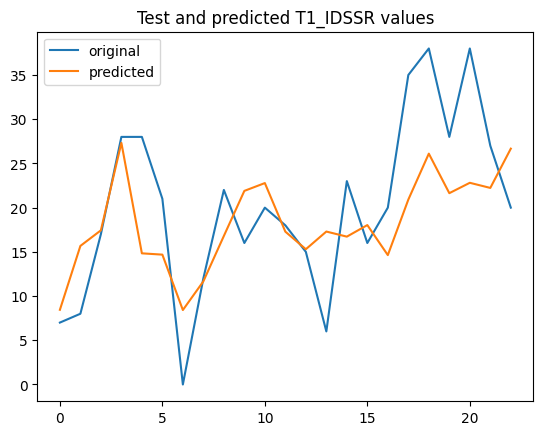

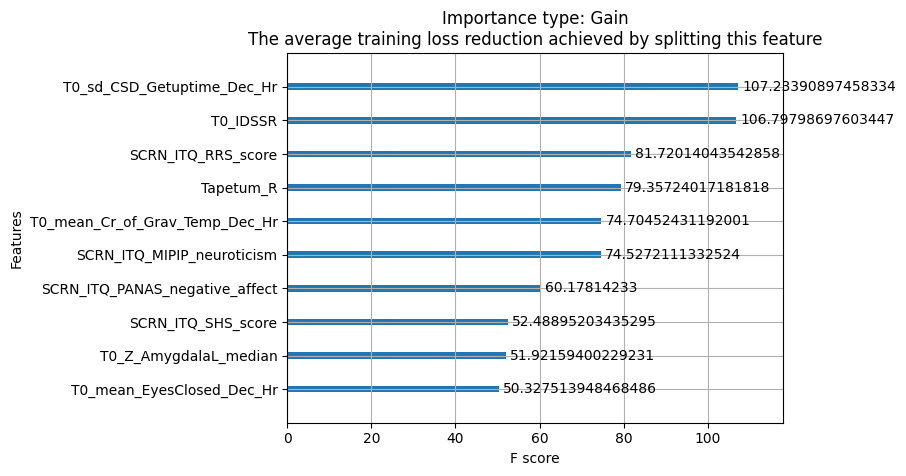

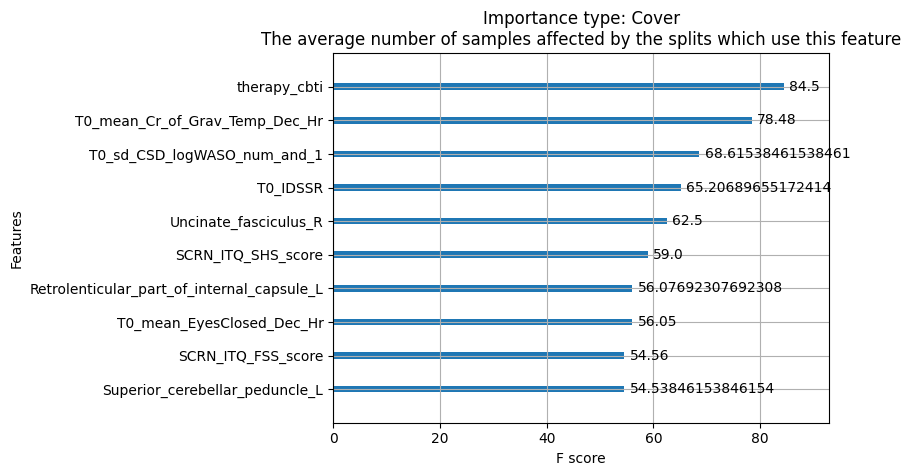

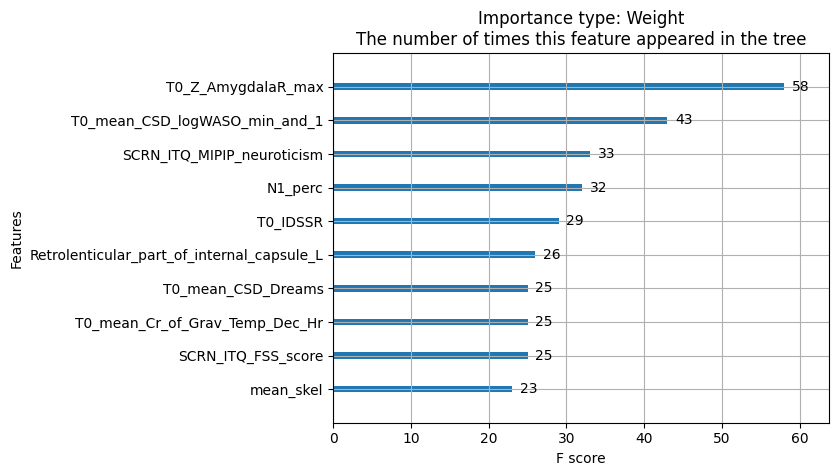

In [ ]:
plt.style.use('default')
#--------------------------------------------------------------------------------------------------
# XGBoost using XGBRegressor
print('%%%%%%% XGBoost Regression:')

xg_reg = XGBRegressor(objective="reg:squarederror", params=rparams)
xg_reg.fit(X_train, y_train)
score = xg_reg.score(X_train, y_train)
print("Training score: ", score )
scores = cross_val_score(xg_reg, X_train, y_train,cv=5)
print("Cross-validation scores: {}".format(scores))
predictions = xg_reg.predict(X_valid)
print("R2: " + str(r2_score(y_valid, predictions,multioutput='uniform_average')))
print("RMSE: " + str(np.sqrt(mean_squared_error(y_valid, predictions))))

# TEST VS PREDICTED PLOTS
x_ax = range(len(y_valid))
plt.plot(x_ax, y_valid, label="original")
plt.plot(x_ax, predictions, label="predicted")
plt.title("Test and predicted T1_IDSSR values")
plt.legend()
plt.show()

# IMPORTANCE PLOTS
xgb.importance_type = 'cover'
xgb.plot_importance(xg_reg,max_num_features = 10, title="Importance type: Gain\nThe average training loss reduction achieved by splitting this feature", importance_type='gain')
xgb.plot_importance(xg_reg,max_num_features = 10, title="Importance type: Cover\nThe average number of samples affected by the splits which use this feature", importance_type='cover')
xgb.plot_importance(xg_reg,max_num_features = 10, title="Importance type: Weight\nThe number of times this feature appeared in the tree", importance_type='weight')
plot_tree(xg_reg, 'tree.png')
plt.show()

#--------------------------------------------------------------------------------------------------
# With Cross Validation
# print('%%%%%%% With Cross-validation:')
# print('-- Focus on these results, training sets of above can differ too much --')
# params = {"objective":"reg:squarederror"}
# xg_reg_cross = xgb.train(dtrain=dtrain, params=params)
# xgb_cv = xgb.cv(dtrain=dtrain, params=params, metrics="rmse", as_pandas=True,) 
# print(xgb_cv)

# # IMPORTANCE PLOT 
# xgb.plot_importance(xg_reg_cross,max_num_features = 5, title="Importance type: Gain\nThe average training loss reduction achieved by splitting this feature", importance_type='gain')
# xgb.plot_importance(xg_reg_cross,max_num_features = 5, title="Importance type: Cover\nThe average number of samples affected by the splits which use this feature", importance_type='cover')
# xgb.plot_importance(xg_reg_cross,max_num_features = 5, title="Importance type: Weight\nThe number of times this feature appeared in the tree", importance_type='weight')
# plot_tree(xg_reg_cross, 'tree_cv.png')

# plt.show()

# xgb_cv





#### **Classifier Hyperparameter Tuning: Bayesian Optimization**

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(y_train_cat)
#--------------------------------------------------------------------------------------------------
#Converting the dataframe into XGBoost’s Dmatrix object
dtrain = xgb.DMatrix(X_train_cat, label=le.transform(y_train_cat))

#--------------------------------------------------------------------------------------------------
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth, gamma, n_estimators ,learning_rate):
    params = {'max_depth': int(max_depth),
            'gamma': gamma,
            'n_estimators': int(n_estimators),
            'learning_rate':learning_rate,
            'subsample': 0.8,
            'eta': 0.1,
            'eval_metric': 'rmse'}
    #Cross validating with the specified parameters in 5 folds and 70 iterations
    cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
    #Return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]


#Invoking the Bayesian Optimizer with the specified parameters to tune
xg_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (1, 20),
                                             'gamma': (0, 10),
                                             'learning_rate':(0.01,10),
                                             'n_estimators':(50,120)
                                            })

#--------------------------------------------------------------------------------------------------
#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an #acquisition function of expected improvement
xg_bo.maximize(n_iter=5, init_points=8, acq='ei')

cparams = xg_bo.max['params']

print("Best result: \n {}; \n f(x) = {}.".format(xg_bo.max["params"], xg_bo.max["target"]))



|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        |  nan      |  3.754    |  7.613    |  17.97    |  92.42    |
|  2        |  nan      |  2.768    |  9.922    |  3.198    |  64.58    |
|  3        |  nan      |  5.956    |  8.1      |  17.46    |  91.21    |
|  4        | -inf      |  4.029    |  4.113    |  12.31    |  69.14    |
|  5        | -inf      |  4.536    |  4.323    |  4.193    |  57.35    |
|  6        |  nan      |  8.324    |  5.018    |  6.816    |  97.42    |
|  7        |  nan      |  5.287    |  8.557    |  8.023    |  85.55    |
|  8        | -0.3711   |  5.172    |  0.4958   |  1.442    |  73.85    |


ValueError: ignored

#### XGBoost Classifier

In [ ]:
xg_c = XGBClassifier(params=cparams)
xg_c.fit(X_train_cat, y_train_cat)
# make predictions for test data
y_pred = xg_c.predict(X_valid_cat)
predictions = [value for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_valid_cat, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#### **Permutation Feature Importance**

In [ ]:
perm = PermutationImportance(xg_reg).fit(X_valid, y_valid)
eli5.show_weights(perm, feature_names = X_valid.columns.tolist())

# perm2 = PermutationImportance(xg_c).fit(X_valid_cat, y_valid_cat)
# eli5.show_weights(perm2, feature_names = X_valid.columns.tolist())

display(eli5.show_weights(perm, feature_names = X_valid.columns.tolist()))

# display(eli5.show_weights(perm2, feature_names = X_valid.columns.tolist()))

Weight,Feature
0.2511 ± 0.2652,T0_IDSSR
0.2065 ± 0.0569,diff_ISI_T0_1
0.0620 ± 0.0850,SCRN_ITQ_PI_organization
0.0485 ± 0.1748,Uncinate_fasciculus_R
0.0460 ± 0.1090,T0_mean_Cr_of_Grav_Temp_Dec_Hr
0.0368 ± 0.1280,SCRN_ITQ_PANAS_negative_affect
0.0322 ± 0.0149,Retrolenticular_part_of_internal_capsule_L
0.0208 ± 0.0766,T0_ISI
0.0206 ± 0.0241,T0_sd_CSD_Getuptime_Dec_Hr
0.0183 ± 0.0331,SCRN_ITQ_MIPIP_neuroticism


#### **Partial Dependence Plot**
The name speaks for itself: these plots show how the predictions partially depend on values of the input variables of interest. 


Change the name in feature_name, or pick two features in feature_name_interact. 

**pdp_plot** = plots the partial dependent plot.

**pdp_interact_plot** = shows dependence of one feature on another. 

**target_plot** = plot average target value across different feature values (feature grids)

**target_plot_interact** = plot average target value across different value combinations (feature grid combinations)

**actual_plot** = plot prediction distribution across different feature values (feature grid). Takes XGBoost model. 

**actual_plot_interact** = plot prediction distribution across different feature value combinations (feature grid combinations). Takes XGBoost model. 

TODO: understand the graphs, and pick features :-)



In [ ]:

#----------------------------------------------------------------------------
feature_name = 'T0_IDSSR_no_sleep'
feature_name_interact = X_valid.columns
target = 'T1_IDSSR_no_sleep'
pdp_goals = pdp.pdp_isolate(model=xg_reg, dataset=X_valid, model_features=X_valid.columns.tolist(),feature=feature_name)

#----------------------------------------------------------------------------
pdp.pdp_plot(pdp_goals,feature_name)
plt.show()

inter1 = pdp.pdp_interact(model=xg_reg,
                          dataset=current,
                          model_features= X.columns,
                          features=feature_name_interact,
                          num_grid_points=[10, 10],
                          percentile_ranges=[(5, 95), (5, 95)]
                          )

fig, axes = pdp.pdp_interact_plot(pdp_interact_out=inter1,
                                  feature_names=feature_name_interact,
                                  plot_type='contour',
                                  x_quantile=True,
                                  plot_pdp=True)

#----------------------------------------------------------------------------
fig, axes, summary_df = info_plots.target_plot(df=df_T0, target=target ,feature = feature_name, feature_name=feature_name)
plt.show()

fig, axes, summary_df = info_plots.target_plot_interact(df=df_T0, target=target ,features = feature_name_interact, feature_names=feature_name_interact)
plt.show()

#----------------------------------------------------------------------------
fig, axes, summary_df = info_plots.actual_plot(model=xg_reg, X=X,feature = feature_name, feature_name=feature_name)
plt.show()

fig, axes, summary_df = info_plots.actual_plot_interact(model=xg_reg, X=X, features = feature_name_interact, feature_names=feature_name_interact)
plt.show()

#### **SHAP-values**

**Global Interpretability**

In [ ]:
shap.initjs()

explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(X_valid)
shap.summary_plot(shap_values, X_valid, plot_type="bar")

# Positive and negative relationships of the predictors with the target variable
shap.summary_plot(shap_values, X_valid)

# Partial dependence plot. 
shap.dependence_plot("T0_ISI", shap_values, X_valid)




### Run RandomForestRegressor

A bagging algorithm. Bagging is when you create different models by resampling your data to make the resulting model more robust.

Note: XGBoost is a boosting algorithm. Boosting is telling the subsequent model what errors the previous models made.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, y)

print(rf_random.best_params_)


# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(rf, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

# features = X.columns
# importances = regressor.feature_importances_
# indices = np.argsort(importances)

# plt.title('Feature Importances')
# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), [features[i] for i in indices])
# plt.xlabel('Relative Importance')
# plt.show()

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_valid, y_valid)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_valid, y_valid)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(8).plot(kind='barh')

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_valid, y_valid)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

